In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr.model import Policy, FlexBase
import umap
%run representation_analysis
%run model_evaluation

In [2]:
def split_by_ep(targets, dones):
    done_idxs = np.where(np.vstack(dones))[0]
    split_targets = []
    for i in range(len(done_idxs)):
        if i == 0:
            done_targets = targets[:done_idxs[i]]
        else:
            done_targets = targets[done_idxs[i-1]:done_idxs[i]]

        split_targets.append(done_targets)
    return split_targets

def draw_box(env=None, corner=None, size=None, ax=None, c='y'):
    if env is not None:
        for box in env.boxes:
            if box.is_goal:
                corner = box.corner
                size = box.size
                break
    else:
        if corner is None:
            corner = np.array([240, 60])
        if size == None:
            size = [20, 20]
    if type(size) != list:
        size = [size, size]
        
    box_array = np.vstack([
        corner,
        corner+np.array([0, size[1]]),
        corner+np.array([size[0], size[1]]),
        corner+np.array([size[0], 0]),
        corner
    ]).T
    
    if ax == None:
        plt.plot(box_array[0], box_array[1], c=c)
    else:
        ax.plot(box_array[0], box_array[1], c=c)
        
def dones_to_timesteps(dones):
    i=1
    steps = []
    for j, done in enumerate(dones):
        if done[0] == True:
            i = 1
        steps.append(i)
        i += 1
    steps = np.array(steps)
    return steps

In [4]:
print_trained_models()

ppo
├── nav_auxiliary_tasks
│   ├── EXP nav_c2_auxeuclid0: 5
│   ├── EXP nav_c2_auxeuclid1: 5
│   ├── EXP nav_c2_auxeuclid2: 5
│   ├── EXP nav_c2_auxwall1: 5
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 10
│   ├── EXP nav_c4_auxeuclid1: 10
│   ├── EXP nav_c4_auxeuclid2: 10
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_auxiliary_tasks2
│   ├── EXP nav_c2_auxeuclid0: 4
│   ├── EXP nav_c2_auxeuclid1: 4
│   ├── EXP nav_c2_auxeuclid2: 4
│   ├── EXP nav_c2_auxwall1: 2
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 4
│   ├── EXP nav_c4_auxeuclid1: 5
│   ├── EXP nav_c4_auxeuclid2: 5
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_invisible_shared
│   ├── EXP nav_c4_shared0.dist: 5
│   ├── EXP nav_c4_shared0: 5
│   ├── EXP nav_c4_shared1.dist: 5
│   ├── EXP nav_c4_shared1: 5
│   ├── EXP nav_c4_shared2.dist: 5
│   ├── EXP nav_c4_shared2: 5
├── nav_invisible_shared2
│   ├── EXP nav_c2_shared0: 5
│   ├── EXP nav_c2_share

In [3]:
# model_name = 'nav_poster2/nav_pproxim_auxeuclid0'
model_name = 'nav_poster2/nav_pproxim_auxwall2'
# model_name = 'nav_invisible_shared2/nav_pproxim_shared2'

#Generate episodes
eps = perform_ep_collection(model_name, model_num=0, random_actions=False, num_episodes=100,
                           data_callback=poster_data_callback)

#Get episodes statistics
stacked = stack_activations(eps['activations'])
pos = np.vstack(eps['data']['pos'])
dones = np.vstack(eps['dones'])
angles = np.vstack(eps['data']['angle'])
poster_seen = np.vstack(eps['data']['poster_seen'])
poster_in_view = np.vstack(eps['data']['poster_in_view'])

ep_pos = split_by_ep(pos, dones)
ep_angles = split_by_ep(angles, dones)
ep_poster_seen = split_by_ep(poster_seen, dones)
ep_poster_in_view = split_by_ep(poster_in_view, dones)

steps = dones_to_timesteps(dones)
ep_steps = split_by_ep(steps, dones)

#Reduce activations of shared layer
# reducer = umap.UMAP(random_state=0, n_neighbors=30, min_dist=0)
# reduced = reducer.fit_transform(stacked['shared_activations'][0])



### UMAP projections

In [14]:
neighbors = [10, 15, 30, 60]
min_dist = [0, 0.1, 0.3, 0.5]
all_umaps = []
for i, neighbor in enumerate(neighbors):
    all_umaps.append([])
    for j, dist in enumerate(min_dist):
        all_umaps[i].append(None)
activations = stacked['shared_activations'][0]

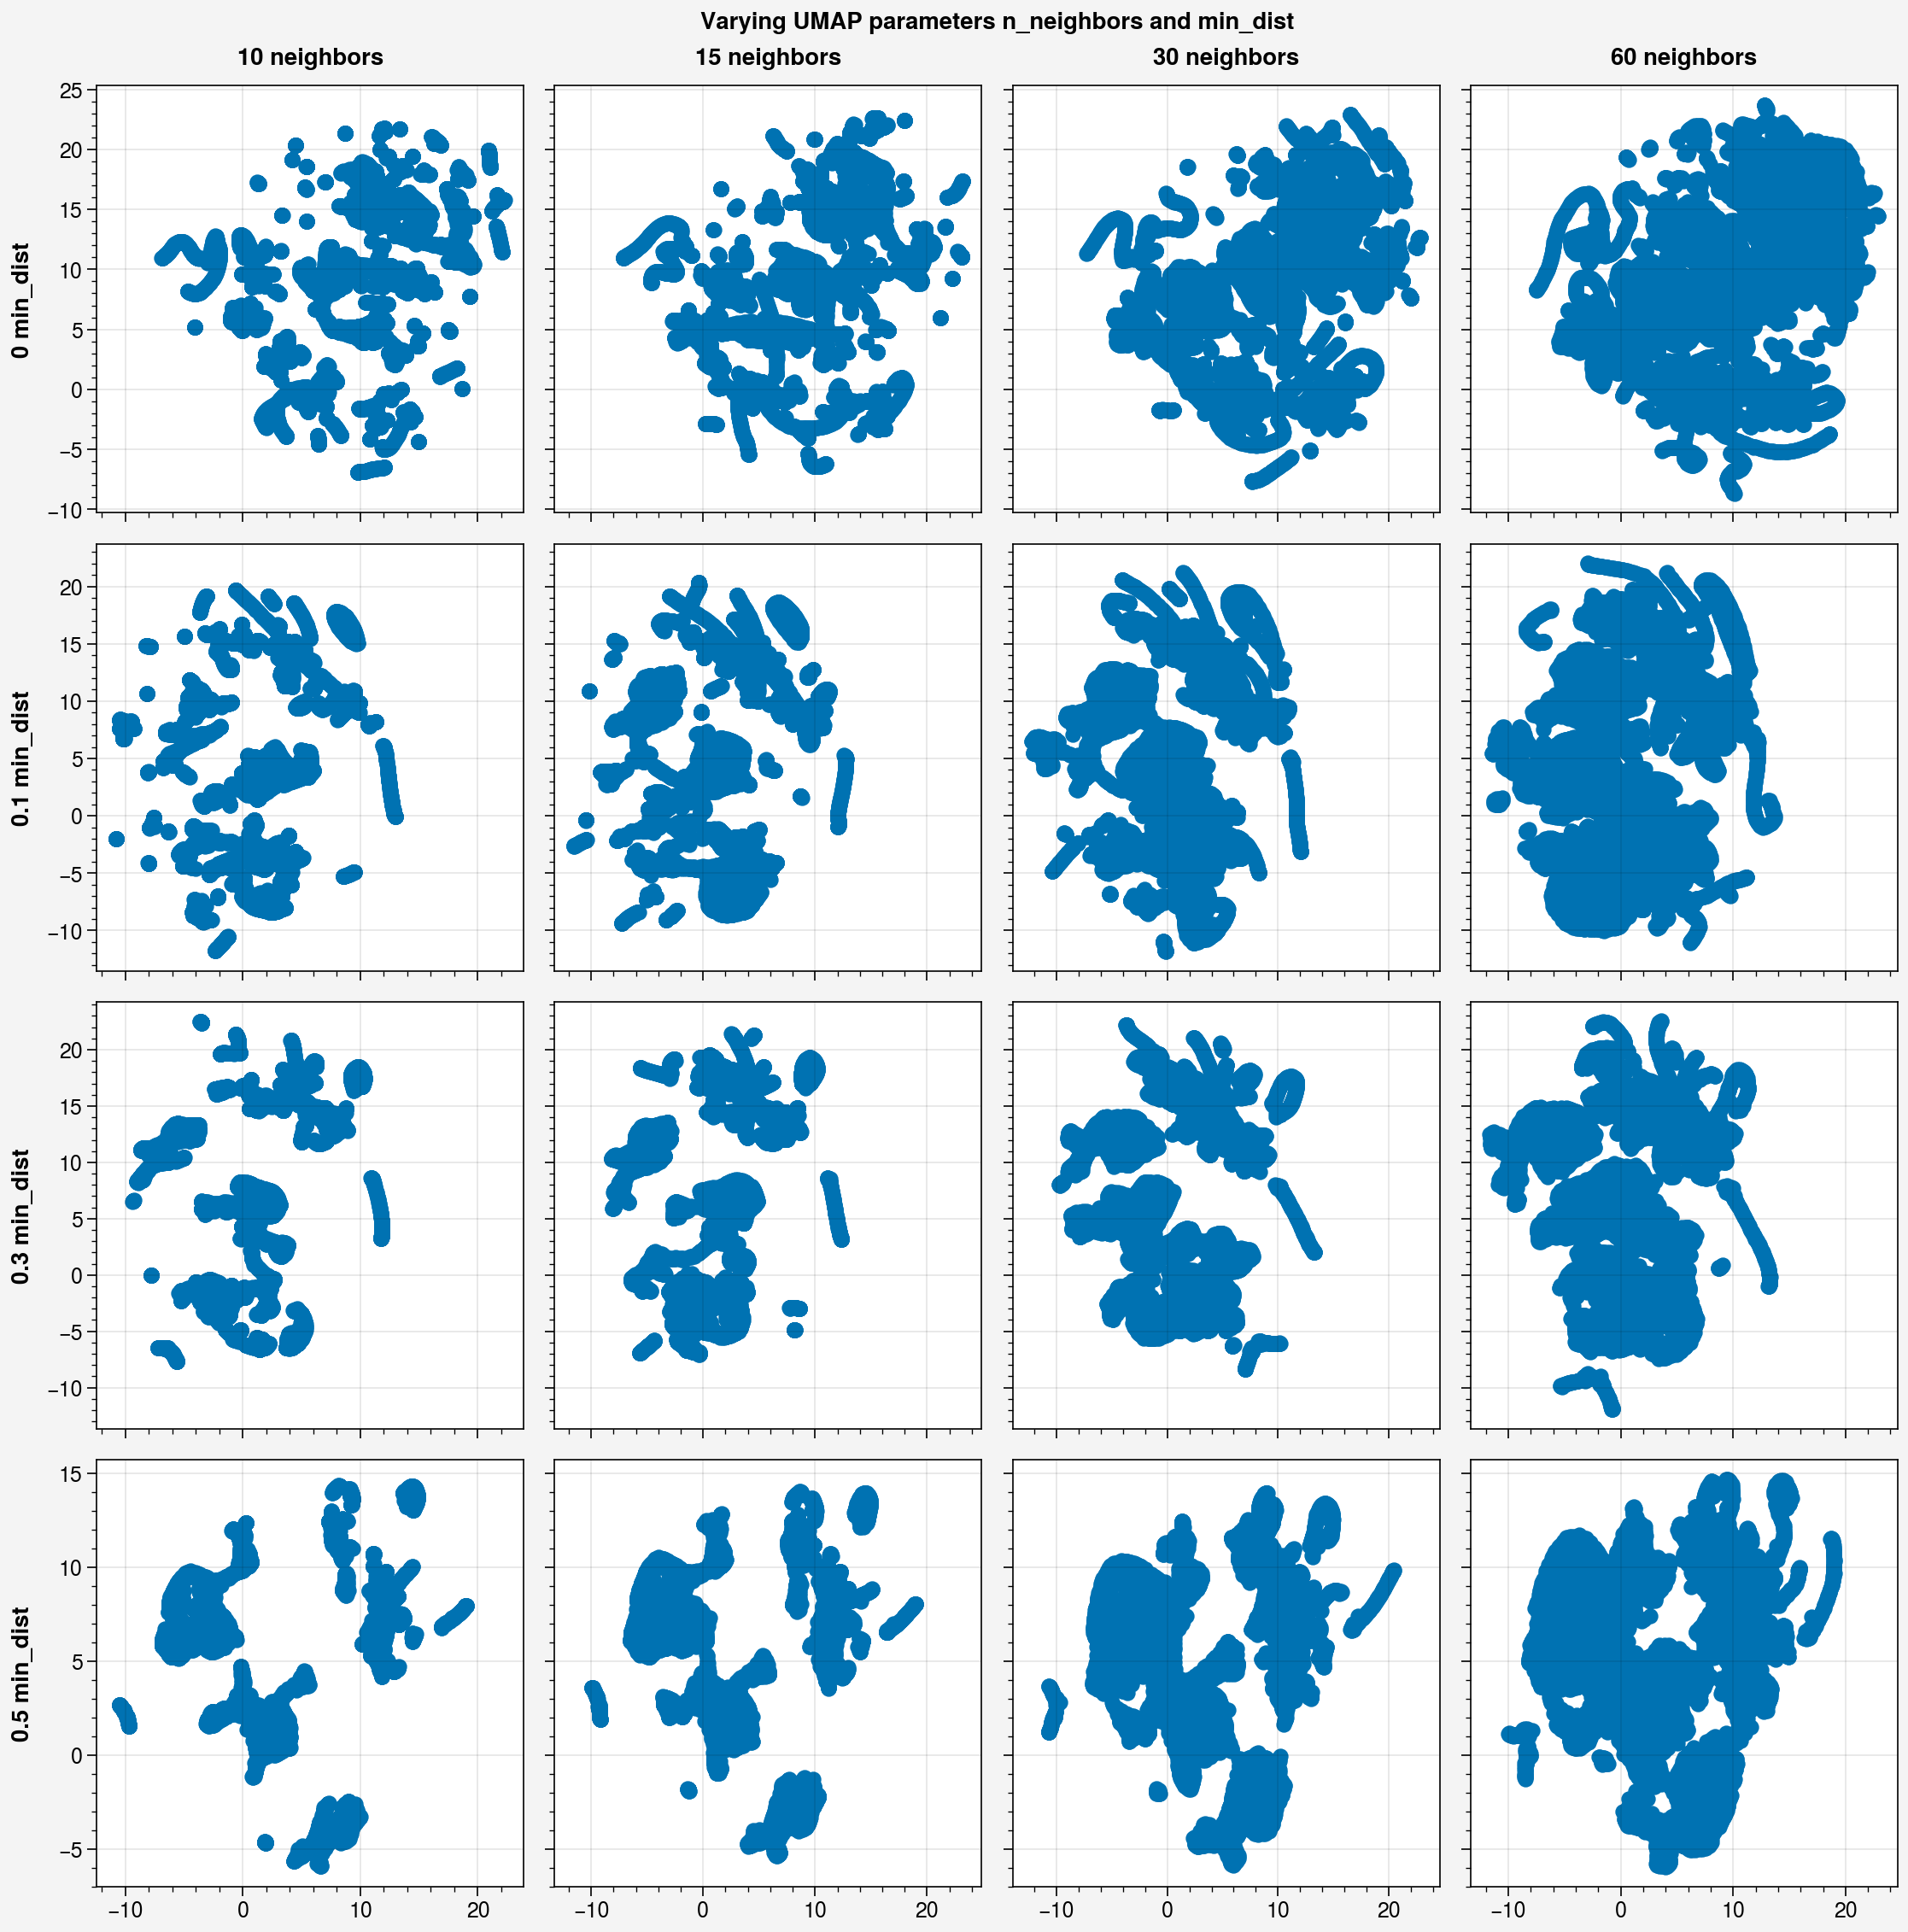

In [18]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
ax.format(toplabels=[f'{n} neighbors' for n in neighbors],
          leftlabels=[f'{w} min_dist' for w in min_dist],
          suptitle='Varying UMAP parameters n_neighbors and min_dist')

for i, neighbor in enumerate(neighbors):
    for j, dist in enumerate(min_dist):
        if all_umaps[i][j] == None:
            #Generate mapper
            reducer = umap.UMAP(random_state=0, n_neighbors=neighbor, min_dist=dist)
            reducer.fit(activations)
            all_umaps[i][j] = reducer
        else:
            reducer = all_umaps[i, j]
        
        reduced = reducer.transform(activations)
        ax[i, j].scatter(reduced.T[0], reduced.T[1])
        

In [55]:
all_umaps_full = all_umaps.copy()

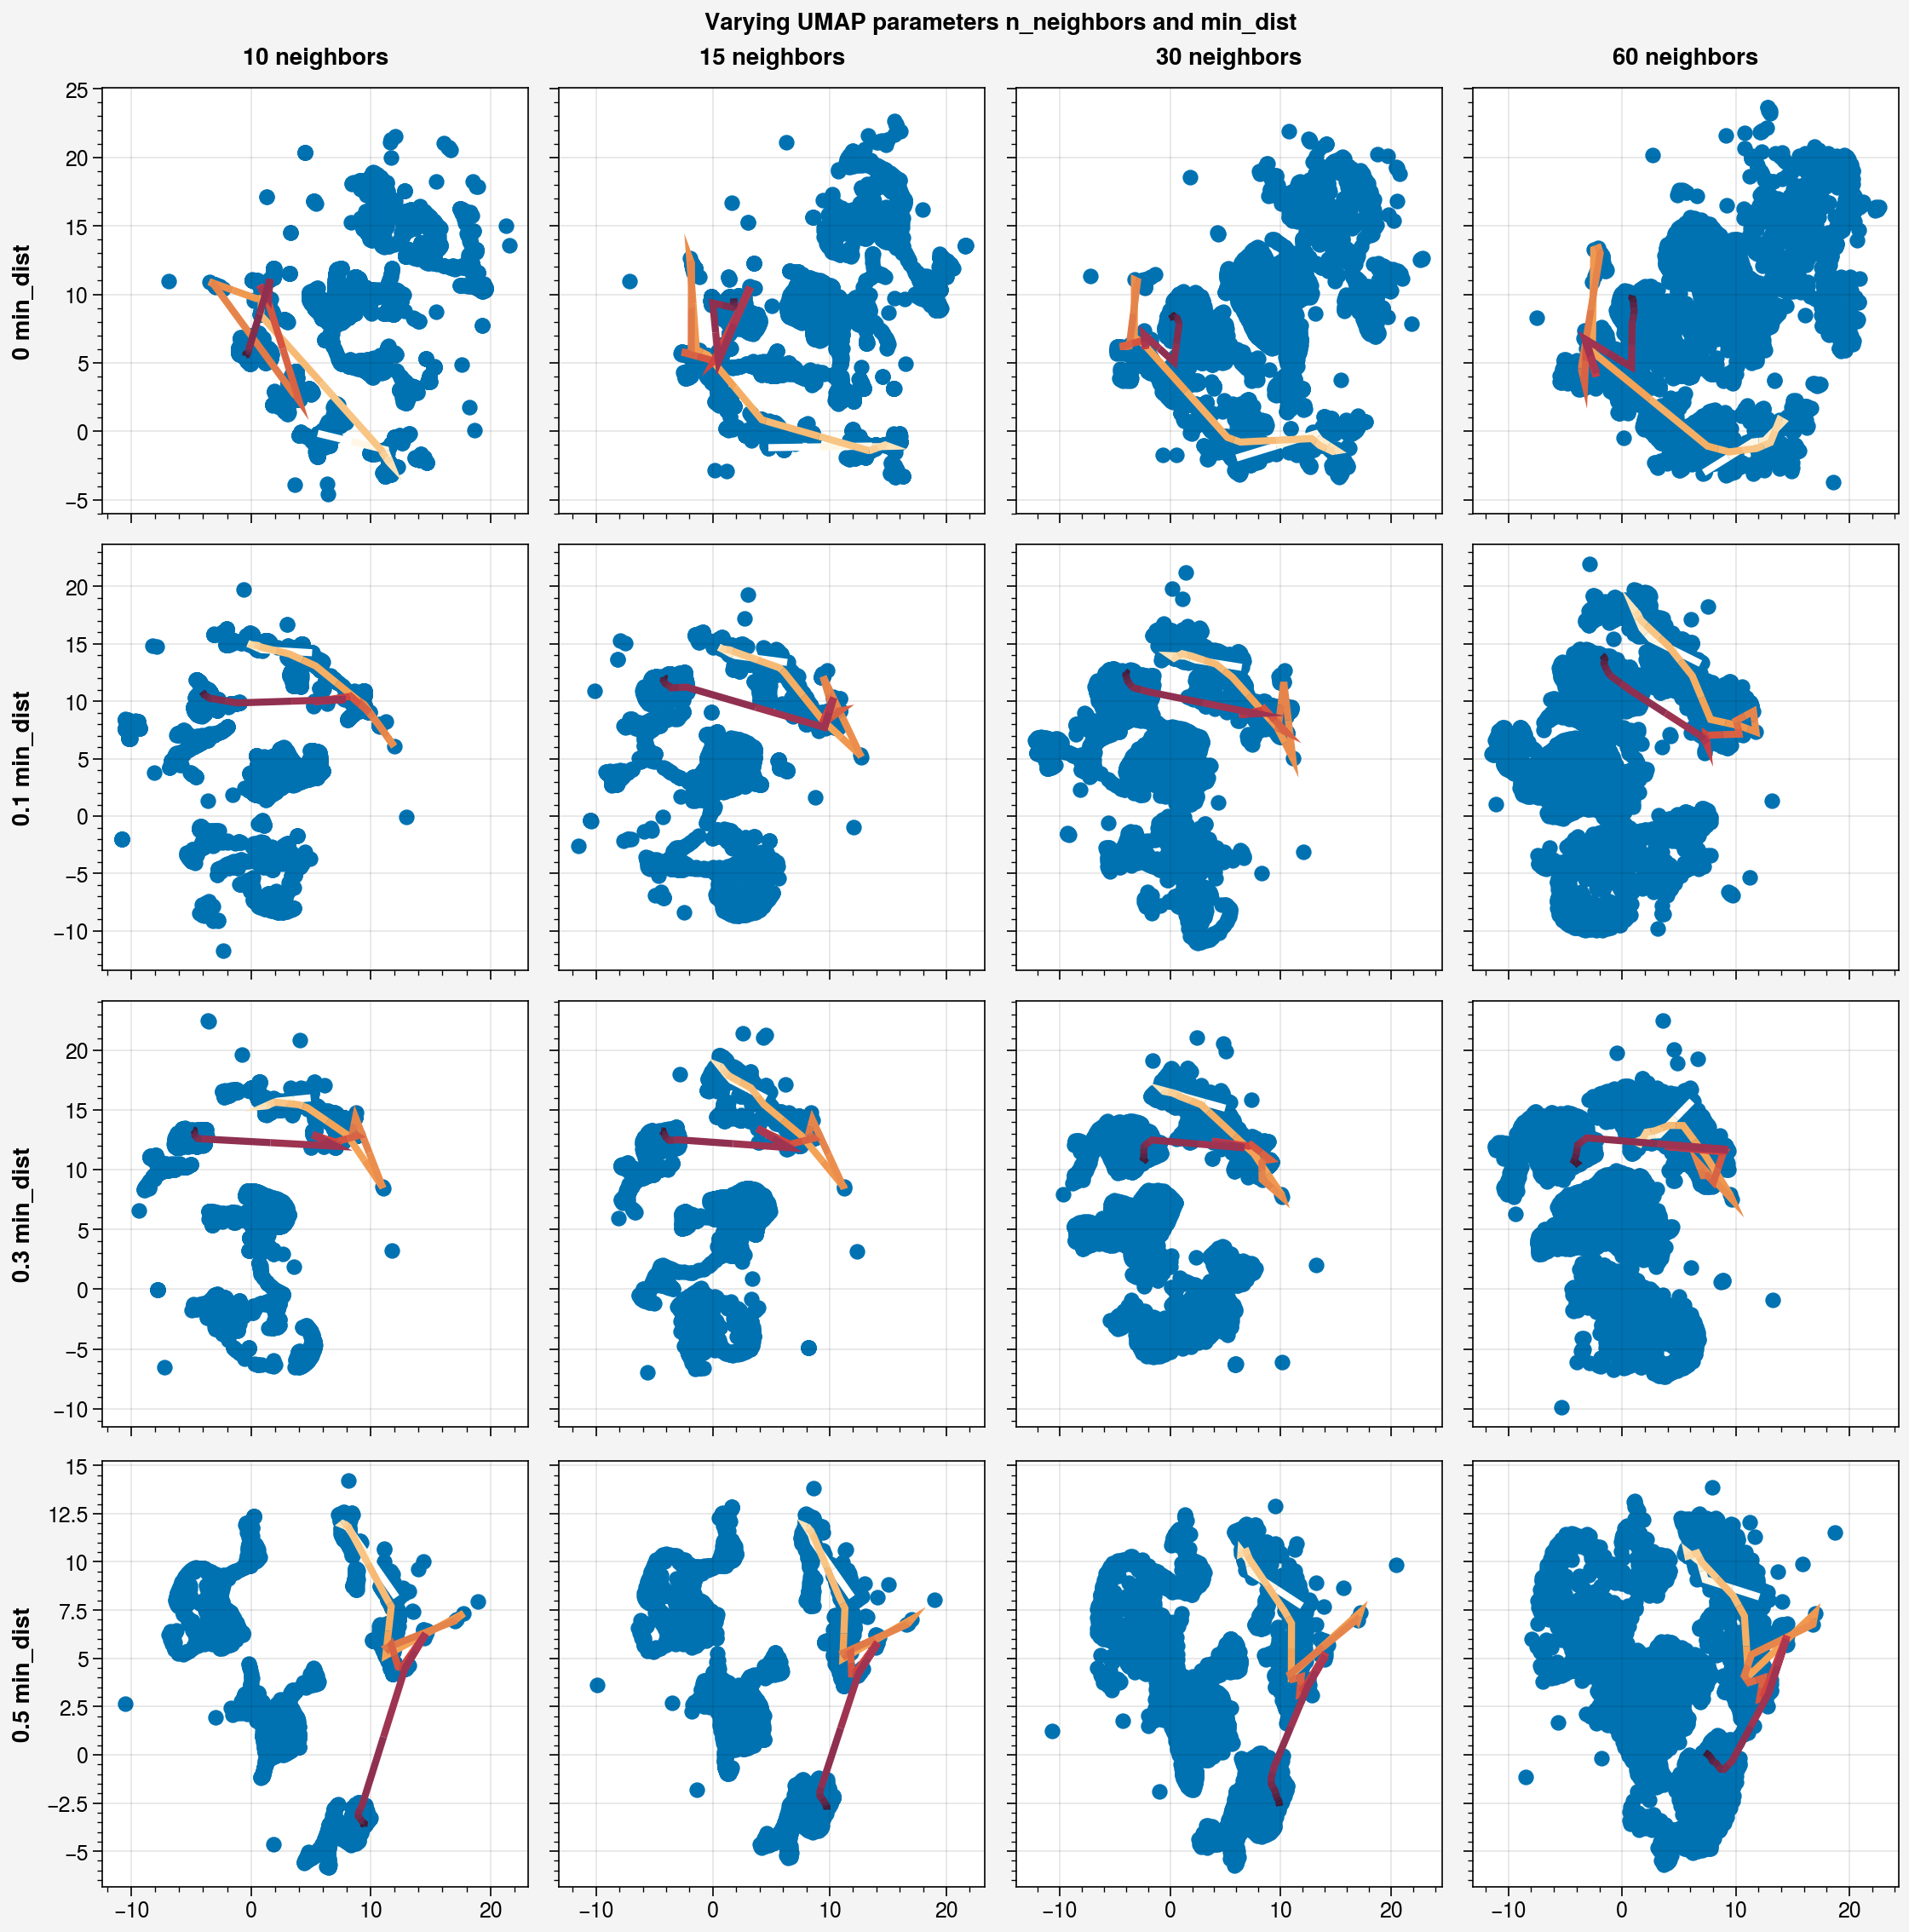

In [54]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
ax.format(toplabels=[f'{n} neighbors' for n in neighbors],
          leftlabels=[f'{w} min_dist' for w in min_dist],
          suptitle='Varying UMAP parameters n_neighbors and min_dist')

#Assume we performed UMAP reduction on all episodes
for i, neighbor in enumerate(neighbors):
    for j, dist in enumerate(min_dist):
        # if all_umaps[i][j] == None:
        #     #Generate mapper
        #     reducer = umap.UMAP(random_state=0, n_neighbors=neighbor, min_dist=dist)
        #     reducer.fit(activations)
        #     all_umaps[i][j] = reducer
        # else:
        reducer = all_umaps[i][j]
        reduced = reducer.transform(activations)
        ep_pruned = prune_fail_episodes(reduced, dones)
        pruned = np.vstack(ep_pruned).T
        
        ax[i, j].scatter(pruned[0], pruned[1])
        ax[i, j].parametric(ep_pruned[1].T[0], ep_pruned[1].T[1], lw=3)
        
        
        

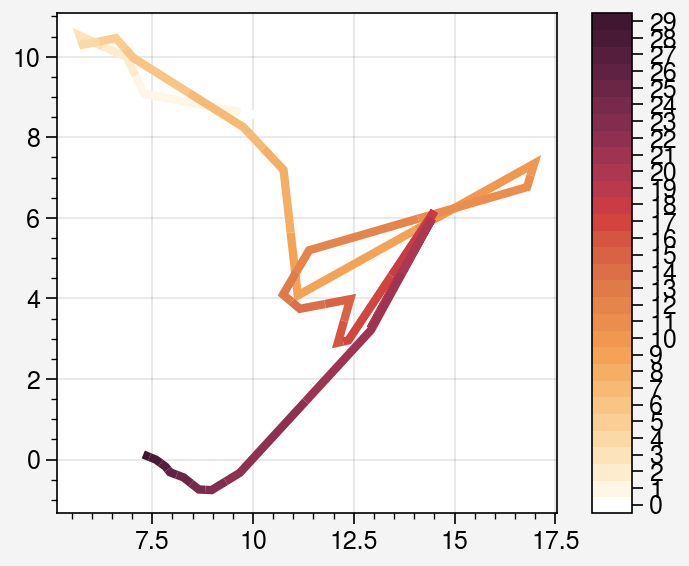

In [53]:
fig, ax = pplt.subplots(ncols=2)

ax.parametric(ep_pruned[1].T[0], ep_pruned[1].T[1], values=np.arange(len(ep_pruned[1])),
             colorbar=True, lw=3)
# ax.format(colorbar='r')

#### Fit to pruned episodes

Seems like this produces much more consistent plots, with better clustering that trajectories jump less wildly between. Does this mean activations fall into much more consistent pathways?

In [9]:
neighbors = [10, 15, 30, 60]
min_dist = [0, 0.1, 0.3, 0.5]
all_umaps = []
for i, neighbor in enumerate(neighbors):
    all_umaps.append([])
    for j, dist in enumerate(min_dist):
        all_umaps[i].append(None)
activations = stacked['shared_activations'][0]

In [10]:
pruned_dones = prune_fail_episodes(dones, dones)

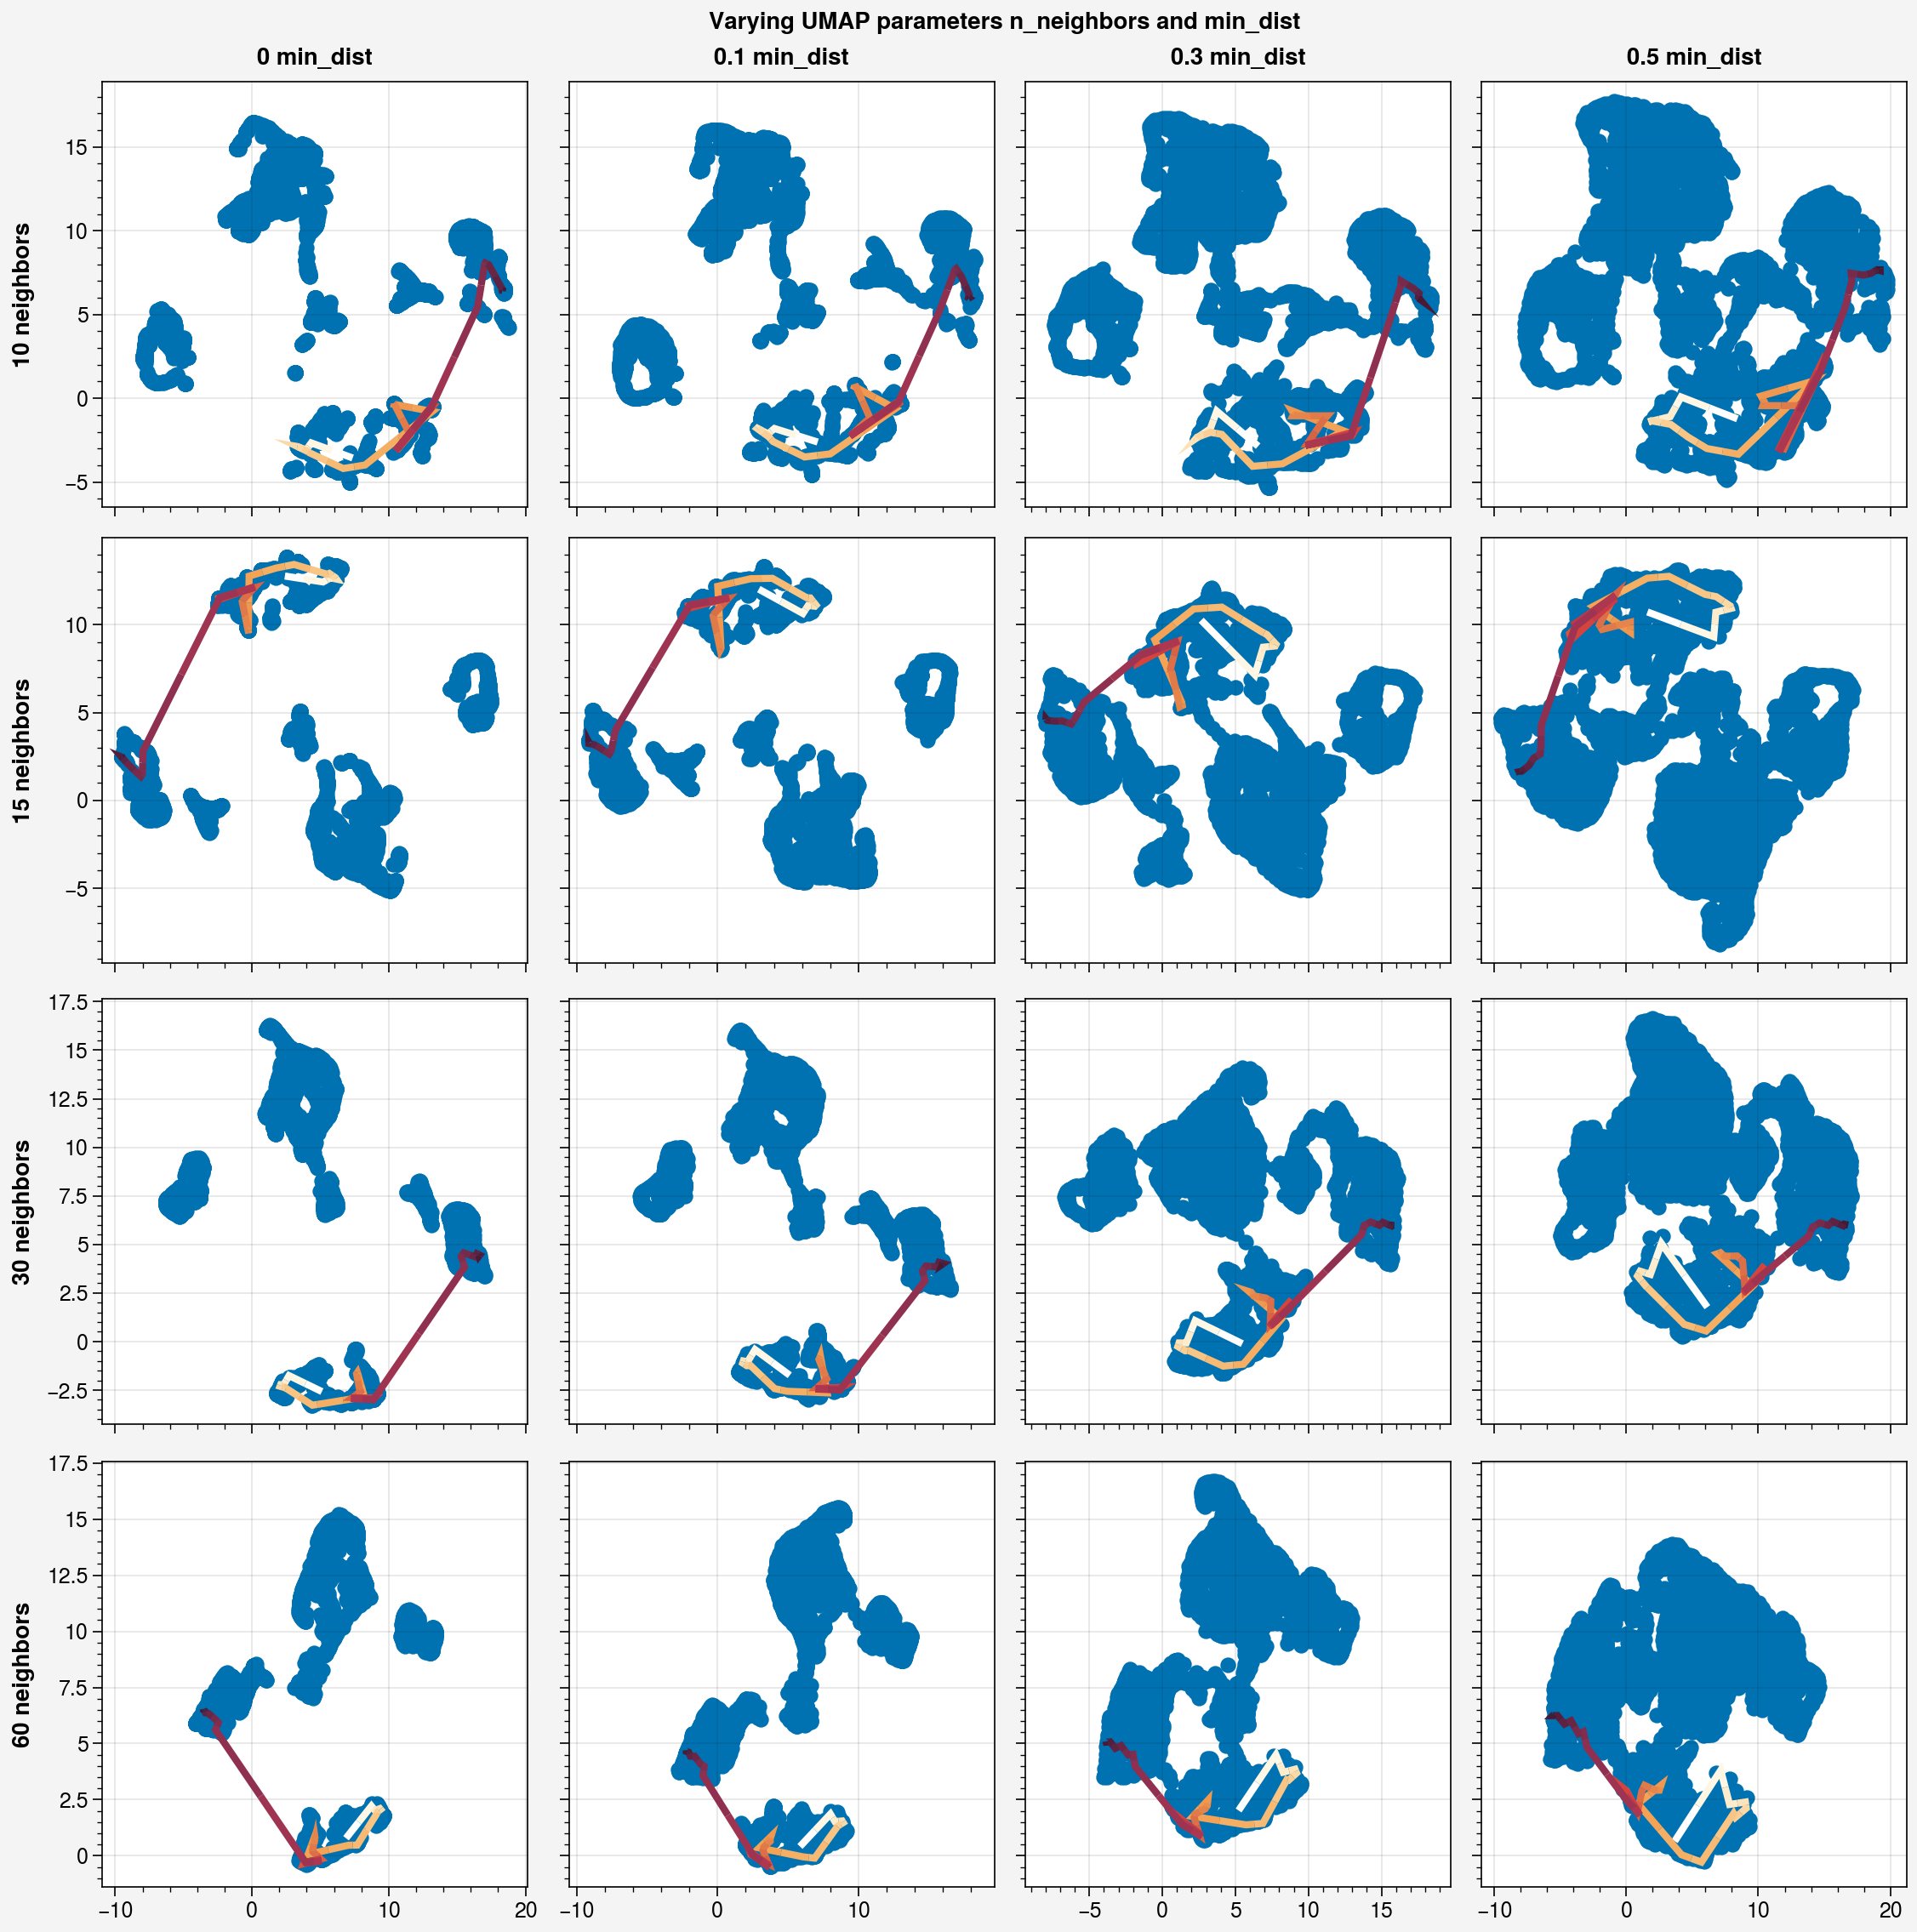

In [36]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
ax.format(leftlabels=[f'{n} neighbors' for n in neighbors],
          toplabels=[f'{w} min_dist' for w in min_dist],
          suptitle='Varying UMAP parameters n_neighbors and min_dist')

ep_pruned = prune_fail_episodes(activations, dones)
pruned_activations = torch.vstack(ep_pruned)
for i, neighbor in enumerate(neighbors):
    for j, dist in enumerate(min_dist):
        if all_umaps[i][j] == None:
            #Generate mapper
            reducer = umap.UMAP(random_state=0, n_neighbors=neighbor, min_dist=dist)
            reducer.fit(pruned_activations)
            all_umaps[i][j] = reducer
        else:
            reducer = all_umaps[i][j]
        
        reduced = reducer.transform(pruned_activations)
        ax[i, j].scatter(reduced.T[0], reduced.T[1])
        
        traj = reducer.transform(ep_pruned[1]).T
        ax[i, j].parametric(traj[0], traj[1], lw=3)

        
        

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


tensor([2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 3, 1, 1, 1, 1, 0, 1, 2, 0, 2, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


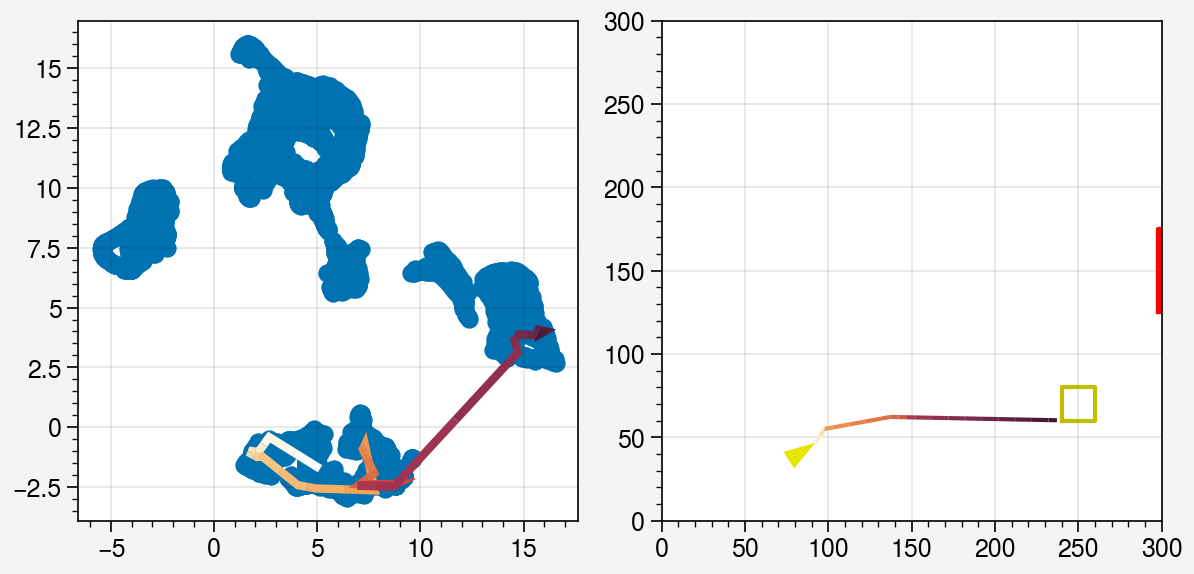

In [37]:
ep_pruned_pos = prune_fail_episodes(pos, dones)
ep_pruned_angle = prune_fail_episodes(angles, dones)
ep_pruned_actions = prune_fail_episodes(eps['actions'], dones)
#Use min_dist 0.5 and 15 neighbors
reducer = all_umaps[2][1]
ep_num = 1

fig, ax = pplt.subplots(ncols=2, share=False)
reduced = reducer.transform(pruned_activations)
ax[0].scatter(reduced.T[0], reduced.T[1])
traj = reducer.transform(ep_pruned[ep_num]).T
ax[0].parametric(traj[0], traj[1], lw=3)

p = ep_pruned_pos[ep_num]
a = ep_pruned_angle[ep_num]
ax[1].parametric(p.T[0], p.T[1])
ax[1].format(xlim=[0, 300], ylim=[0, 300])
draw_character(p[0], a[0], ax=ax[1], size=20)
draw_box(corner=np.array([298, 125]), size=[2, 50], c='r', ax=ax[1])
draw_box(ax=ax[1])
print(torch.vstack(ep_pruned_actions[ep_num]).squeeze())

##### Coloring

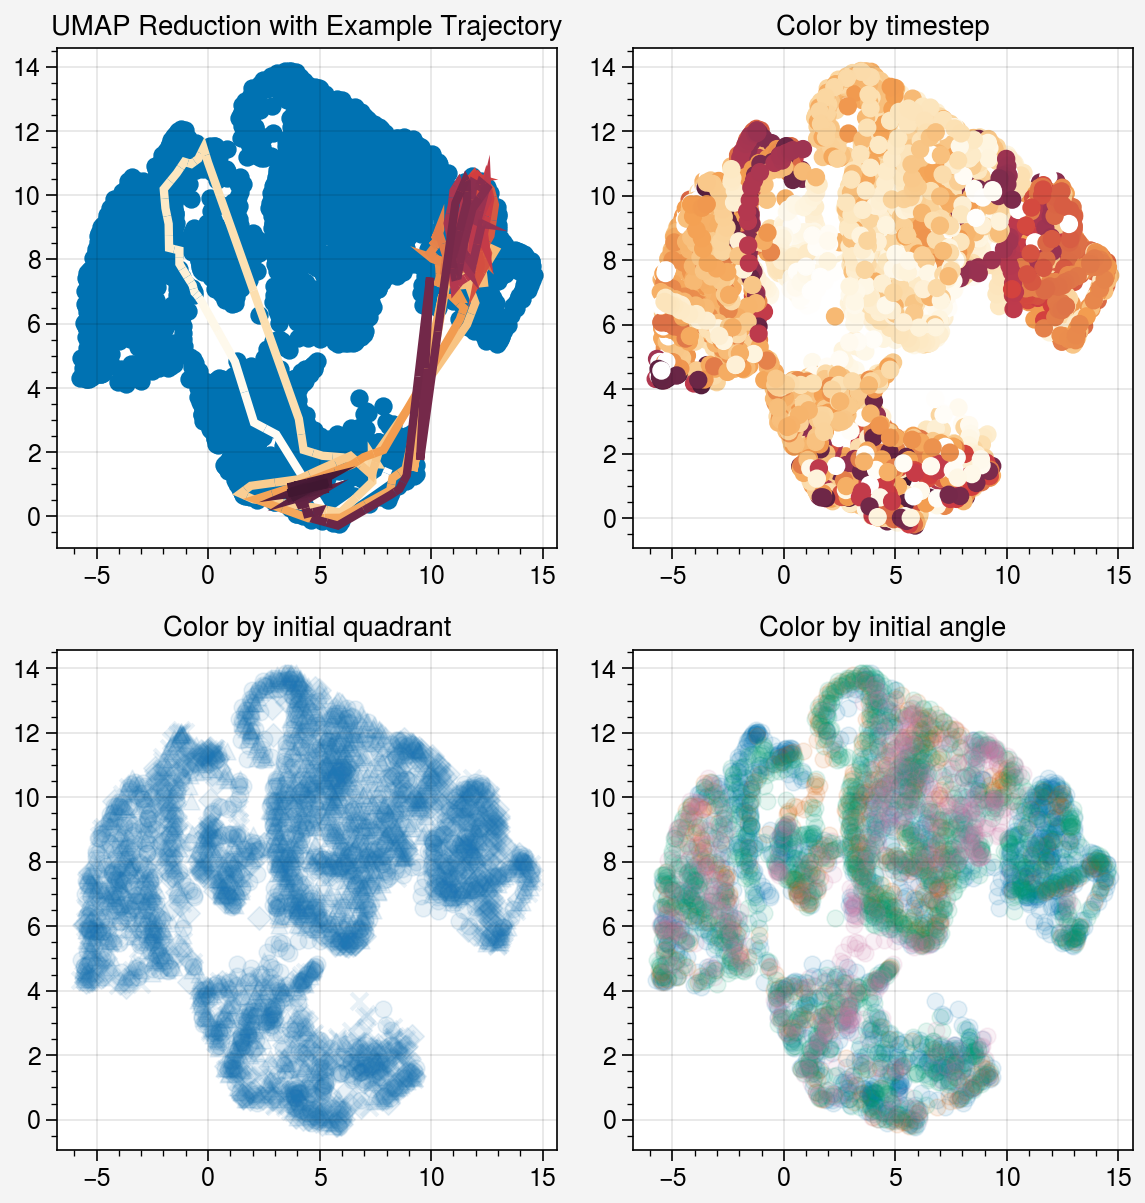

In [31]:
fig, ax = pplt.subplots(nrows=2, ncols=2, share=False)
ax.format(title=['UMAP Reduction with Example Trajectory', 'Color by timestep', 'Color by initial quadrant', 'Color by initial angle',
                'Color and shape by initial cond'])
ep_num=0
reduced = reducer.transform(pruned_activations)
ax[0].scatter(reduced.T[0], reduced.T[1])
traj = reducer.transform(ep_pruned[ep_num]).T
ax[0].parametric(traj[0], traj[1], lw=3)

pruned_steps = np.concatenate(prune_fail_episodes(steps, dones))
ax[1].scatter(reduced.T[0], reduced.T[1], c=pruned_steps)

pruned_ep_pos = prune_fail_episodes(pos, dones)
pruned_ep_angle = prune_fail_episodes(angles, dones)

starting_pos_quad = []
starting_angle_quad = []
for i in range(len(pruned_ep_pos)):
    pos1 = pruned_ep_pos[i][0]
    if pos1[0] >= 150:
        if pos1[1] >= 150:
            quad = 1
        else:
            quad = 4
    else:
        if pos1[1] >= 150:
            quad = 2
        else:
            quad = 3
    starting_pos_quad.append(np.full(pruned_ep_pos[i].shape[0], quad))
    
    angle1 = pruned_ep_angle[i][0]
    if -np.pi/4 <= angle1 <= np.pi/4:
        quad = 1
    elif np.pi/4 < angle1 <= 3*np.pi/4:
        quad = 2
    elif -3*np.pi/4 <= angle1 < -np.pi/4:
        quad = 4
    else:
        quad = 3
    starting_angle_quad.append(np.full(pruned_ep_pos[i].shape[0], quad))
    
starting_pos_quad = np.concatenate(starting_pos_quad)
starting_angle_quad = np.concatenate(starting_angle_quad)
colors = pplt.Cycle('default').by_key()['color']

markers = ['^', 'o', 'x', 'D']
for i in range(len(markers)):
    quad = i+1
    red = reduced[starting_pos_quad == quad]
    ax[2].scatter(red.T[0], red.T[1], marker=markers[i], alpha=0.1, c=colors[0])
for i in range(4):
    quad = i+1
    red = reduced[starting_angle_quad == quad]
    ax[3].scatter(red.T[0], red.T[1], alpha=0.1)


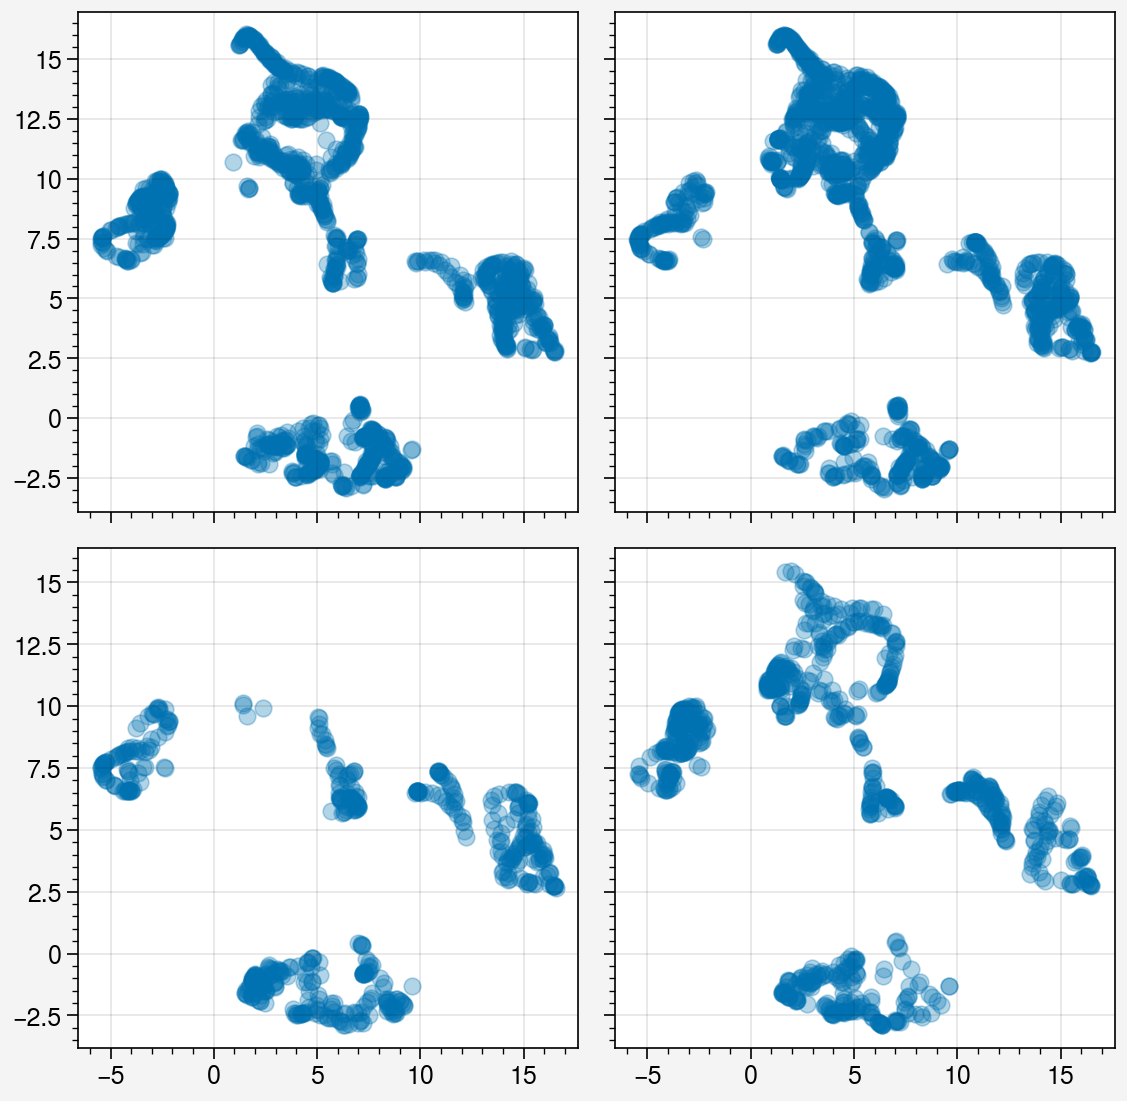

In [38]:
array = [
    [2, 1],
    [3, 4]
]
fig, ax = pplt.subplots(array)
for i in range(4):
    quad = i+1
    red = reduced[starting_pos_quad == quad]
    ax[i].scatter(red.T[0], red.T[1], alpha=0.3)


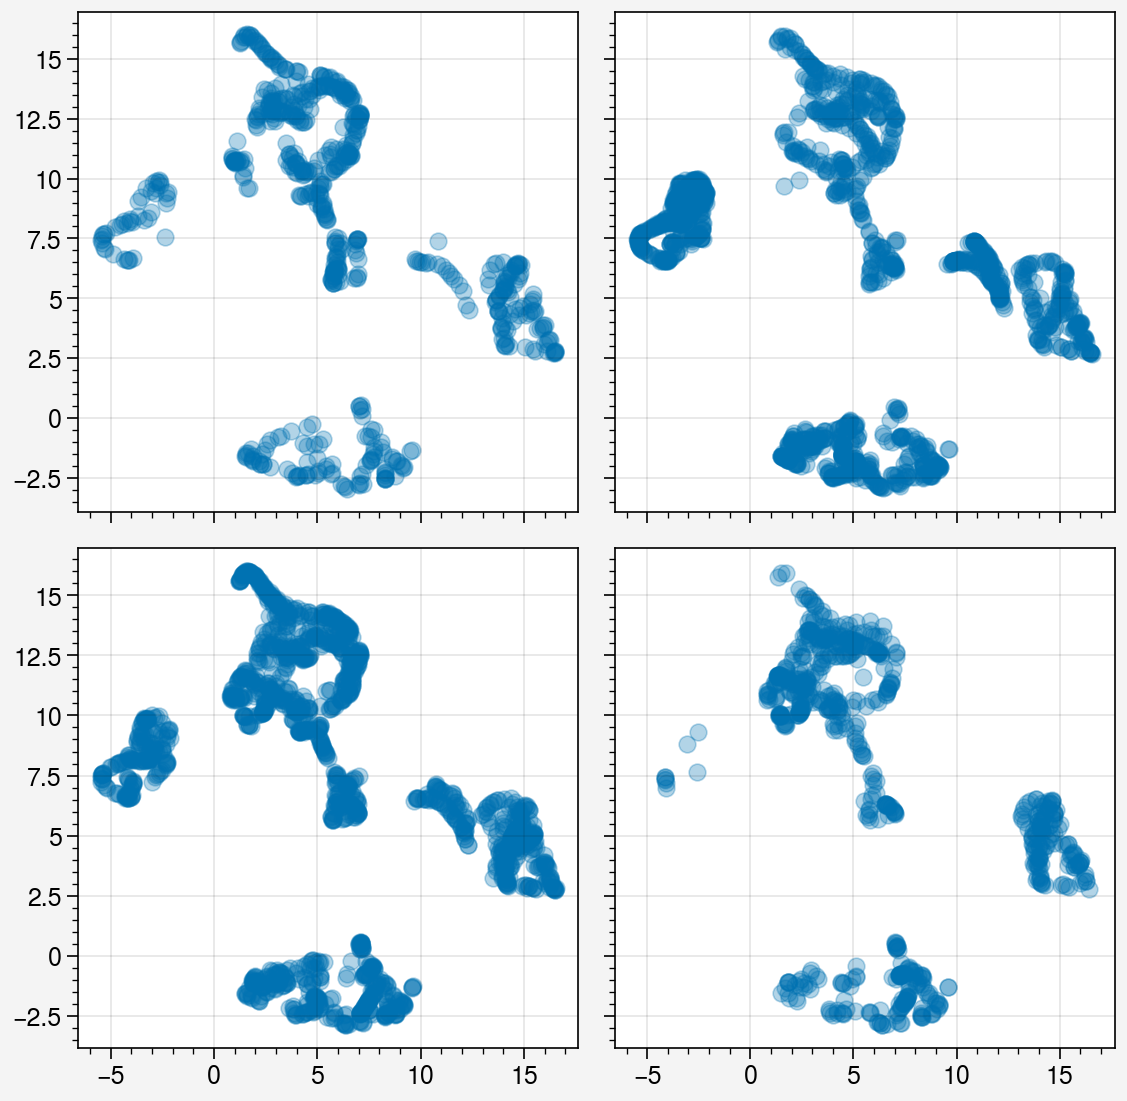

In [39]:
array = [
    [2, 1],
    [3, 4]
]
fig, ax = pplt.subplots(array)
for i in range(4):
    quad = i+1
    red = reduced[starting_angle_quad == quad]
    ax[i].scatter(red.T[0], red.T[1], alpha=0.3)


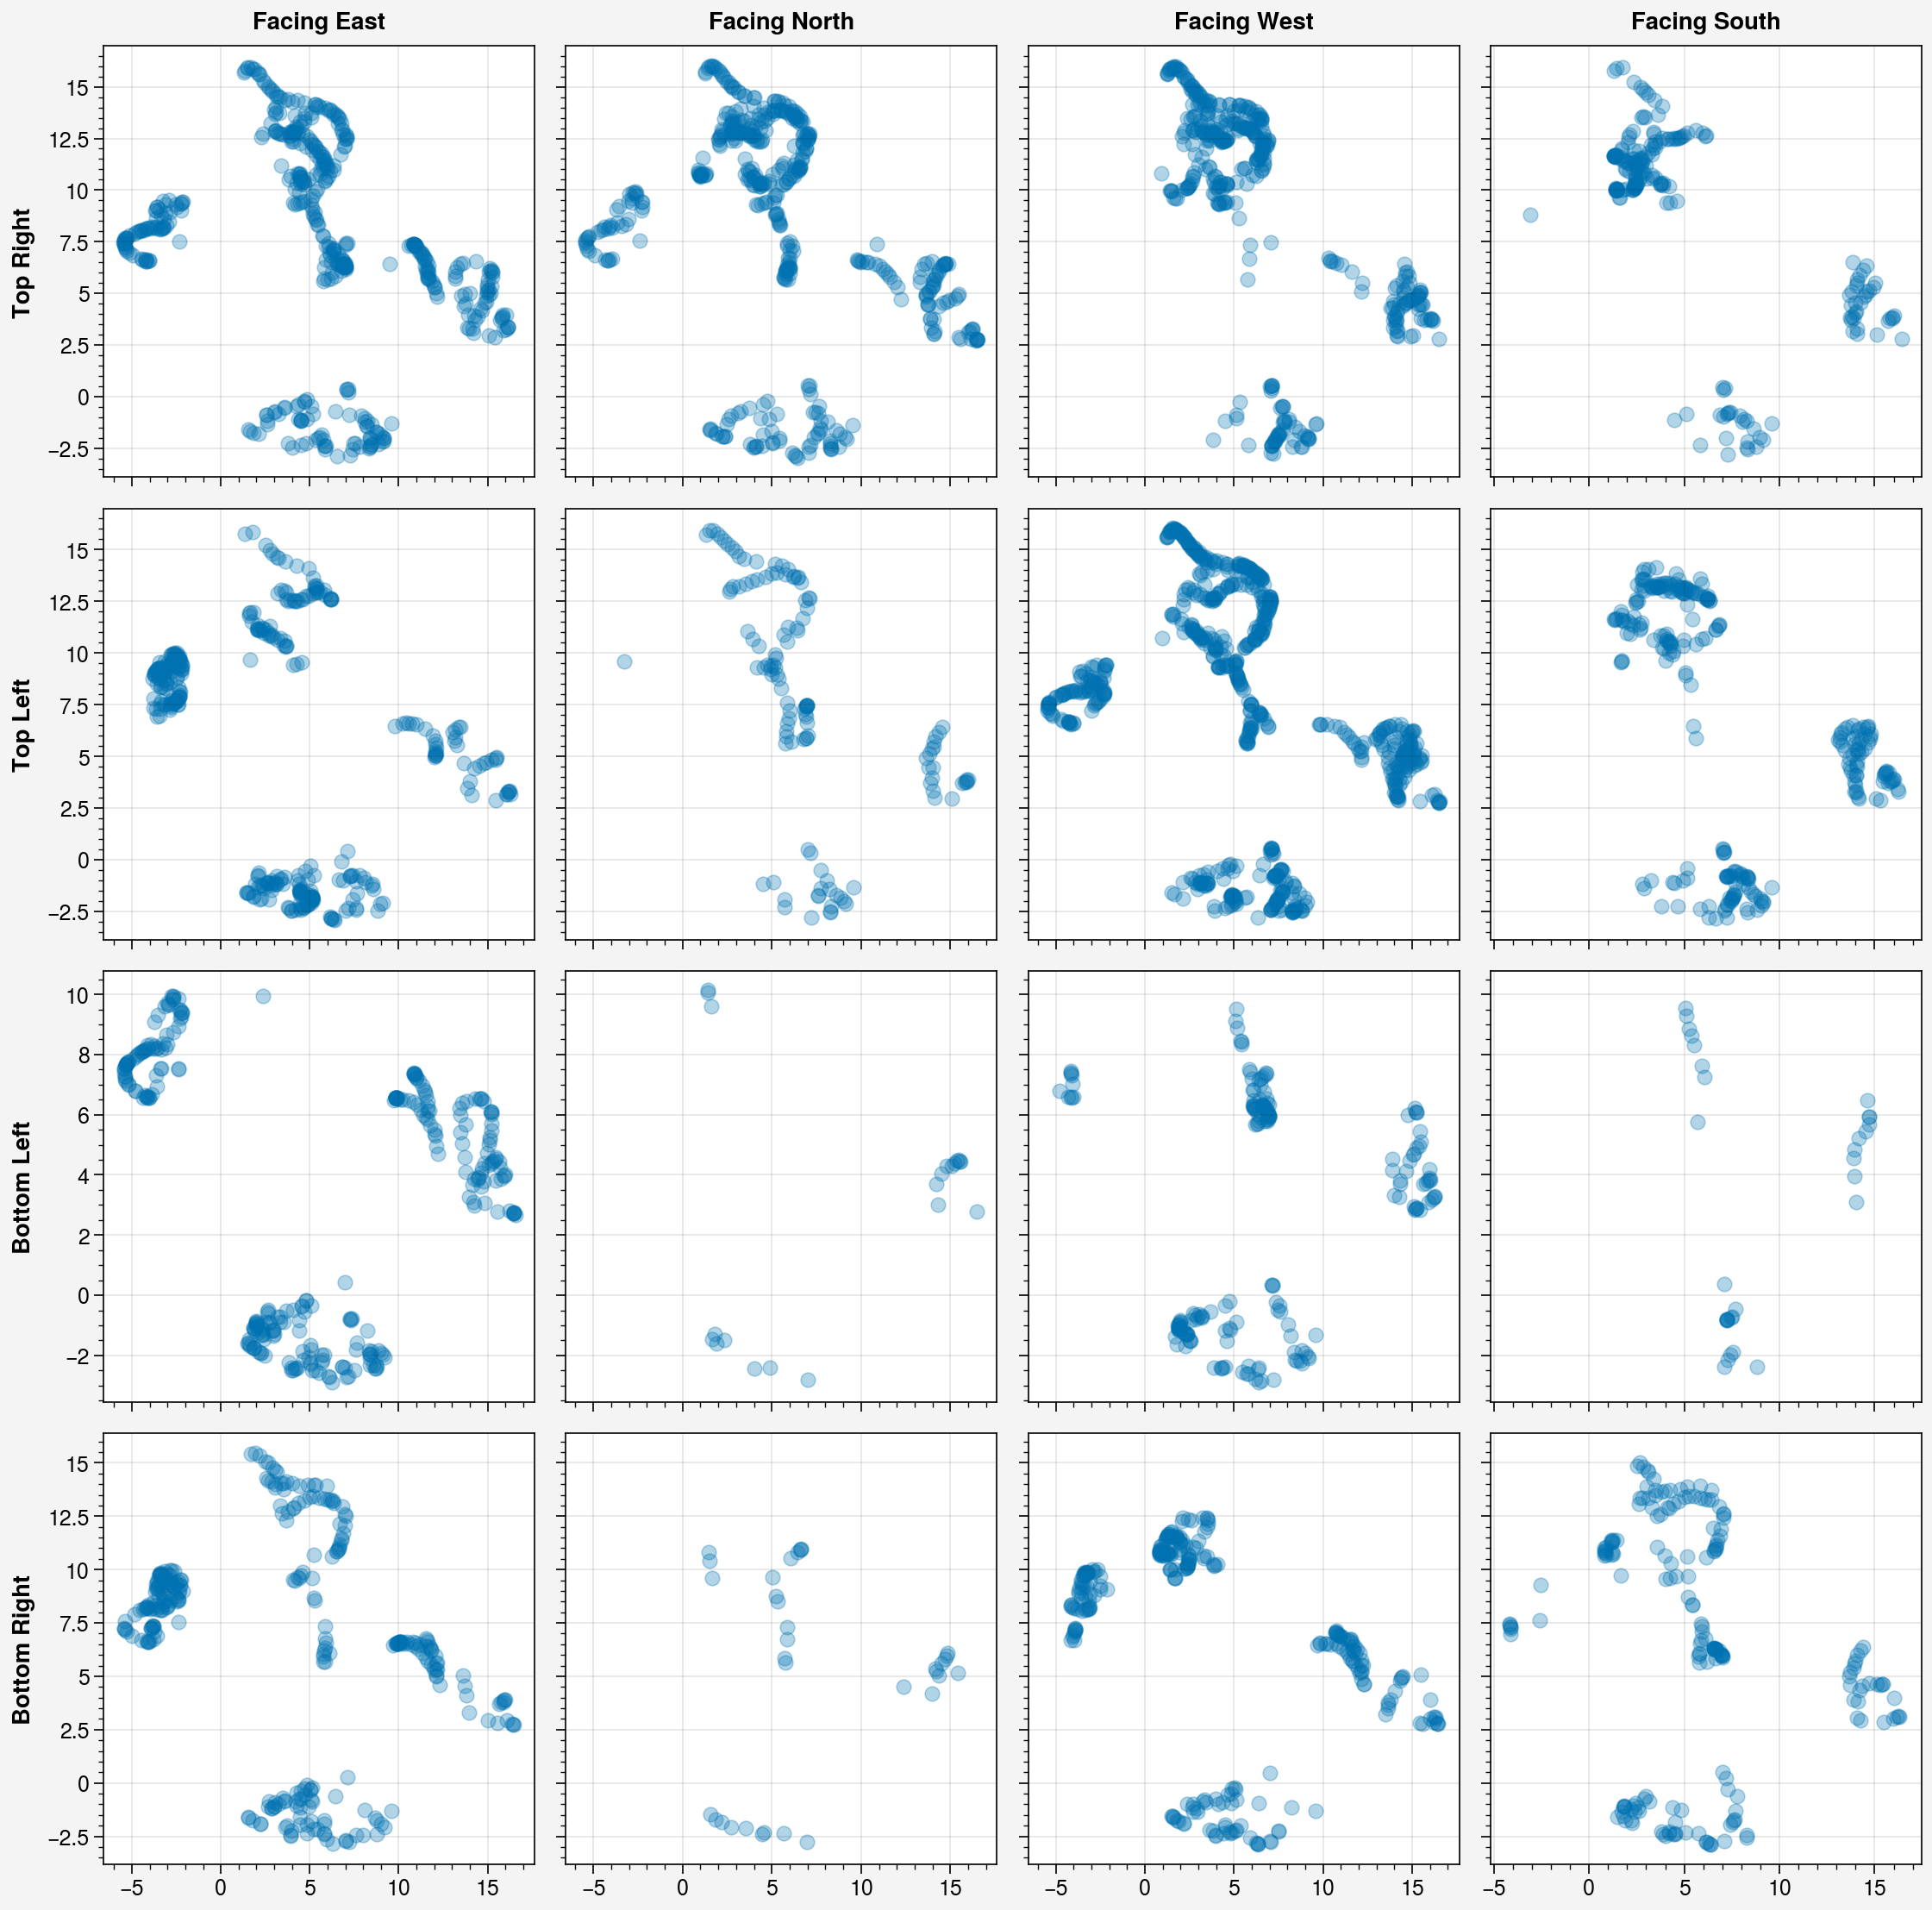

In [40]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
ax.format(toplabels=['Facing East', 'Facing North', 'Facing West', 'Facing South'],
         leftlabels=['Top Right', 'Top Left', 'Bottom Left', 'Bottom Right'])
for i in range(4):
    for j in range(4):
        posquad = i+1
        anglequad = j+1
        red = reduced[(starting_pos_quad == posquad) & (starting_angle_quad == anglequad)]
        ax[i, j].scatter(red.T[0], red.T[1], alpha=0.3)


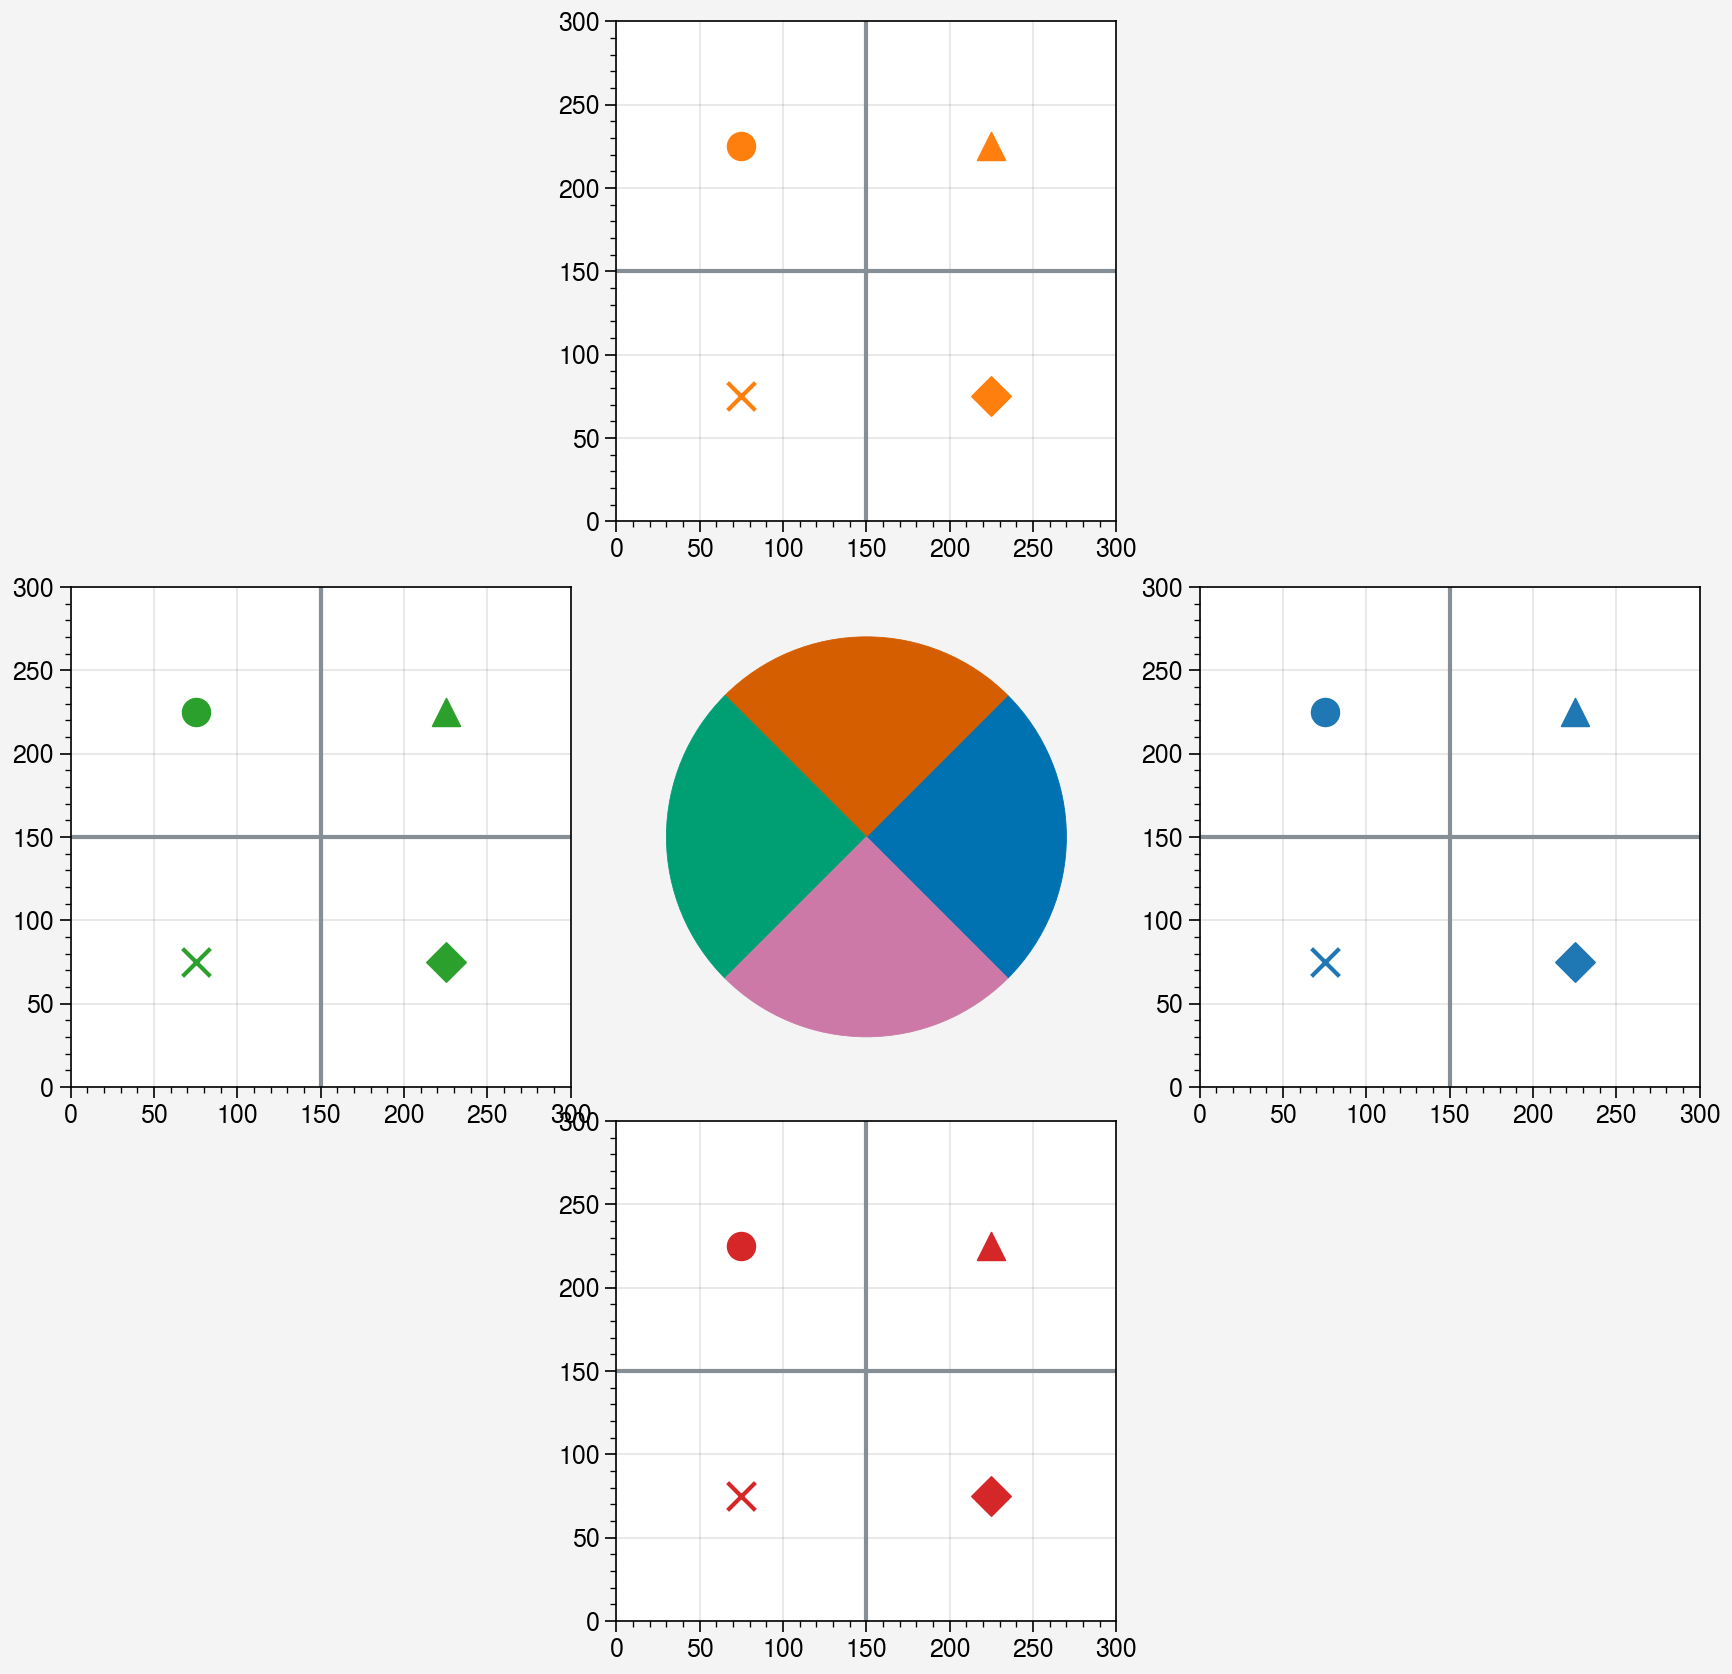

In [8]:
array = [
    [0, 2, 0],
    [3, 5, 1],
    [0, 4, 0]
]
fig, ax = pplt.subplots(array, share=False)
ax.format(xlim=[0, 300], ylim=[0, 300])

ax[4].pie([1, 1, 1, 1], startangle=-45)

colors = pplt.Cycle('default').by_key()['color']
for i in range(4):
    ax[i].hlines([150], [300], c='grey6')
    ax[i].vlines([150], [300], c='grey6')
    ax[i].scatter([225], [225], c=colors[i], marker='^', s=100)
    ax[i].scatter([75], [225], c=colors[i], marker='o', s=100)
    ax[i].scatter([75], [75], c=colors[i], marker='x', s=100)
    ax[i].scatter([225], [75], c=colors[i], marker='D', s=100)


### Episode Statistics

In [56]:
#Calculate what portion of the episode the agent had seen the poster, and how close it got
seen_percs = []
seen_durations = []
min_goal_dists = []
ep_lens = []

goal_center = np.array([250, 70])
for i in range(len(ep_poster_seen)):
    seen_perc = ep_poster_seen[i].sum() / len(ep_poster_seen[i])
    seen_dur = ep_poster_in_view[i].sum() / len(ep_poster_in_view[i])
    seen_percs.append(seen_perc)
    ep_lens.append(len(ep_poster_seen[i]))
    seen_durations.append(seen_dur)
    
    min_goal_dist = np.sqrt(np.sum((ep_pos[i] - goal_center)**2, axis=1)).min()
    min_goal_dists.append(min_goal_dist)


(array([ 6., 13., 20.,  8.,  3.,  0.,  2.,  2.,  2., 44.]),
 array([ 13. ,  31.9,  50.8,  69.7,  88.6, 107.5, 126.4, 145.3, 164.2,
        183.1, 202. ]),
 <BarContainer object of 10 artists>)

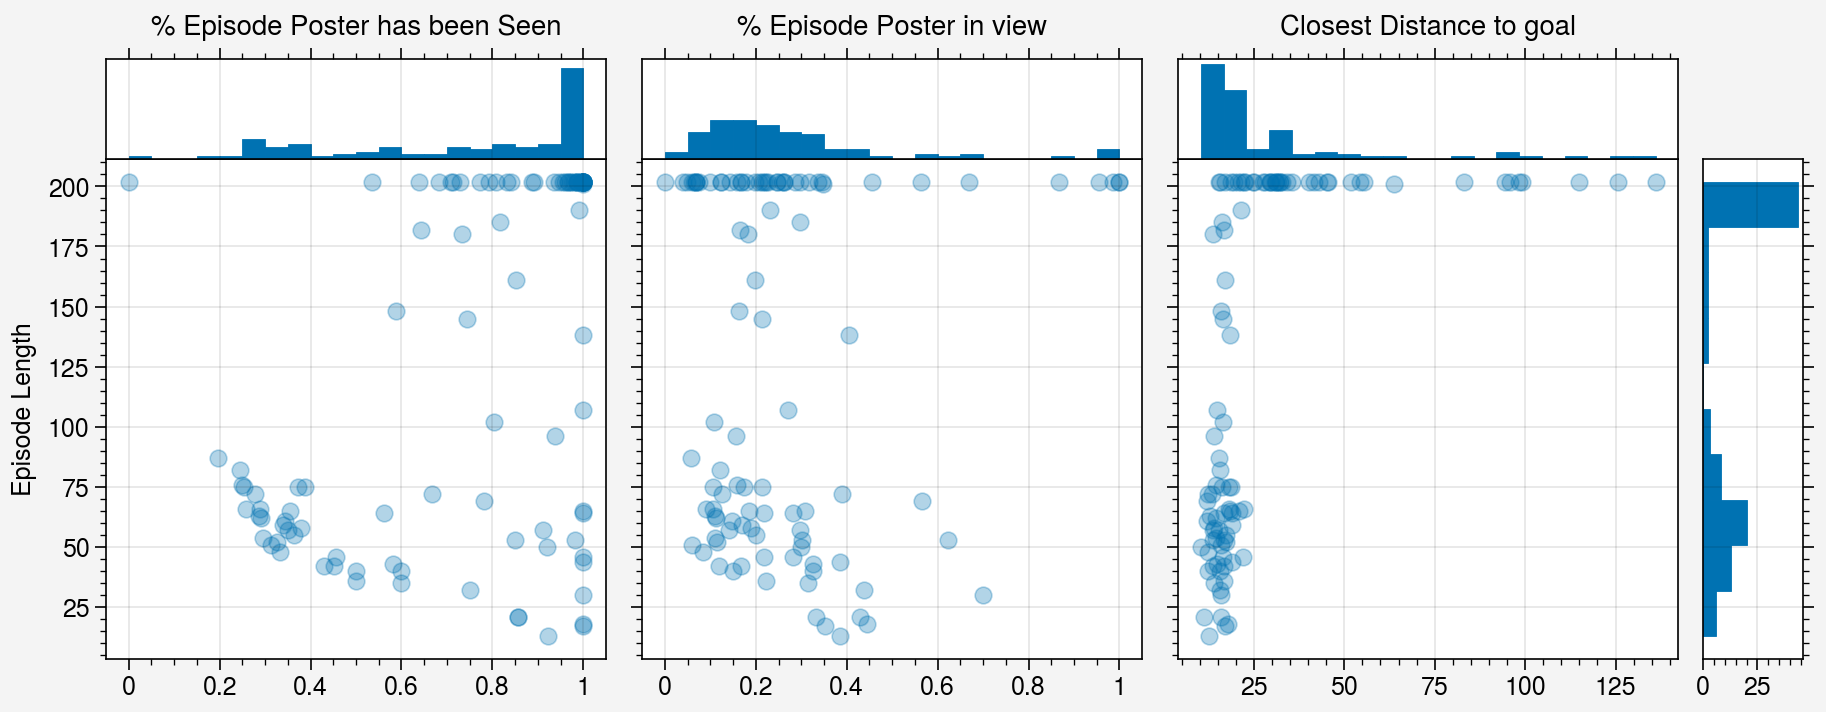

In [64]:
fig, ax = pplt.subplots(ncols=3)
ax.format(title=['% Episode Poster has been Seen', '% Episode Poster in view', 'Closest Distance to goal'],
         ylabel='Episode Length')
taxs = ax.panel('t', space=0, share=True)
taxs.format(yticks=[])
hist_ax = ax[-1].panel('r', space=1, share=True)

values = [seen_percs, seen_durations, min_goal_dists]
for i in range(len(values)):
    ax[i].scatter(values[i], ep_lens, alpha=0.3)
    taxs[i].hist(values[i], bins=20)

hist_ax.histh(ep_lens)
# ax[0].scatter(seen_percs, ep_lens, alpha=0.3)
# ax[1].scatter(seen_durations, ep_lens, alpha=0.3)
# ax[2].scatter(min_goal_dists, ep_lens, alpha=0.3)

In [71]:
np.sum([rew.item() for rew in eps['rewards']])

58.0

In [25]:
model_name = 'nav_poster2/nav_pproxim_auxwall2'
model, obs_rms, kwargs = load_model_and_env(model_name, 0)
eps = evalu(model, obs_rms, n=5, env_kwargs=kwargs, data_callback=poster_data_callback, 
            with_activations=True)


continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue ep
True
continue 

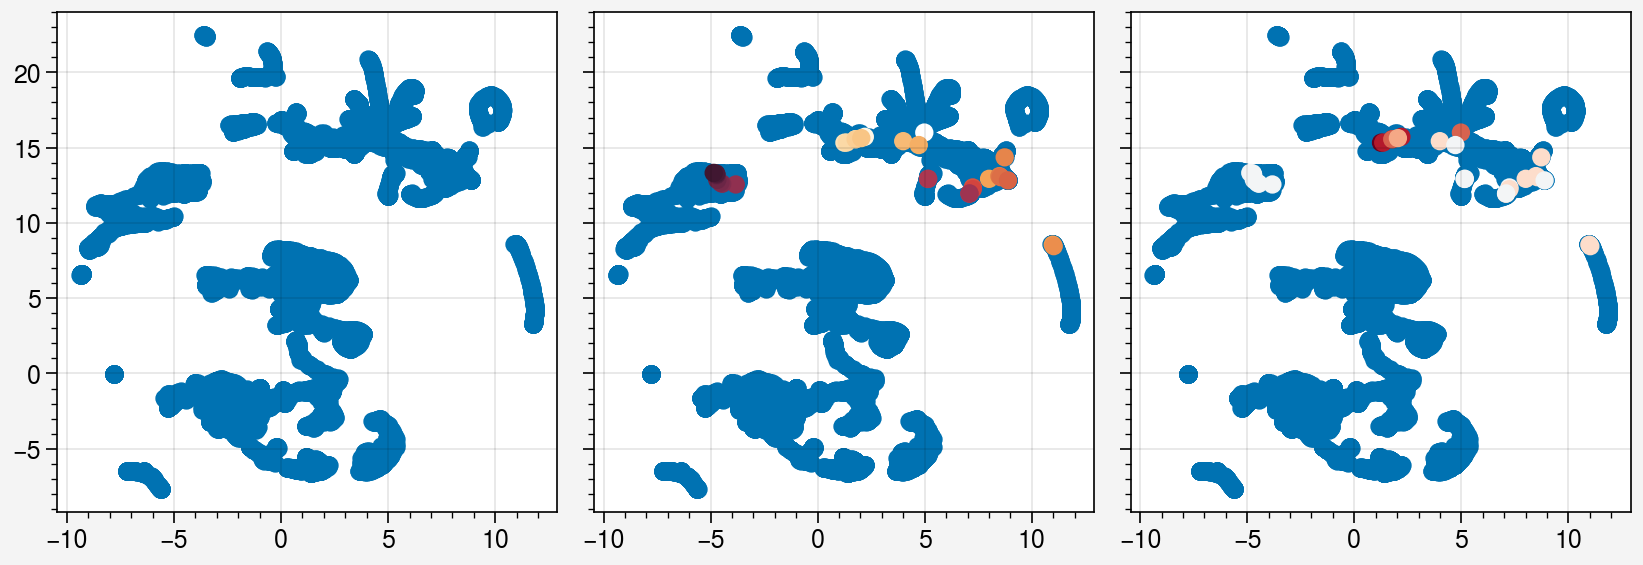

In [123]:
fig, ax = pplt.subplots(ncols=3)
ep_num = 1

for i in range(len(ax)):
    ax[i].scatter(reduced.T[0], reduced.T[1])
ax[1].scatter(ep_reduced[ep_num].T[0], ep_reduced[ep_num].T[1], c=ep_steps[ep_num])
ax[2].scatter(ep_reduced[ep_num].T[0], ep_reduced[ep_num].T[1], c=ep_angles[ep_num])

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


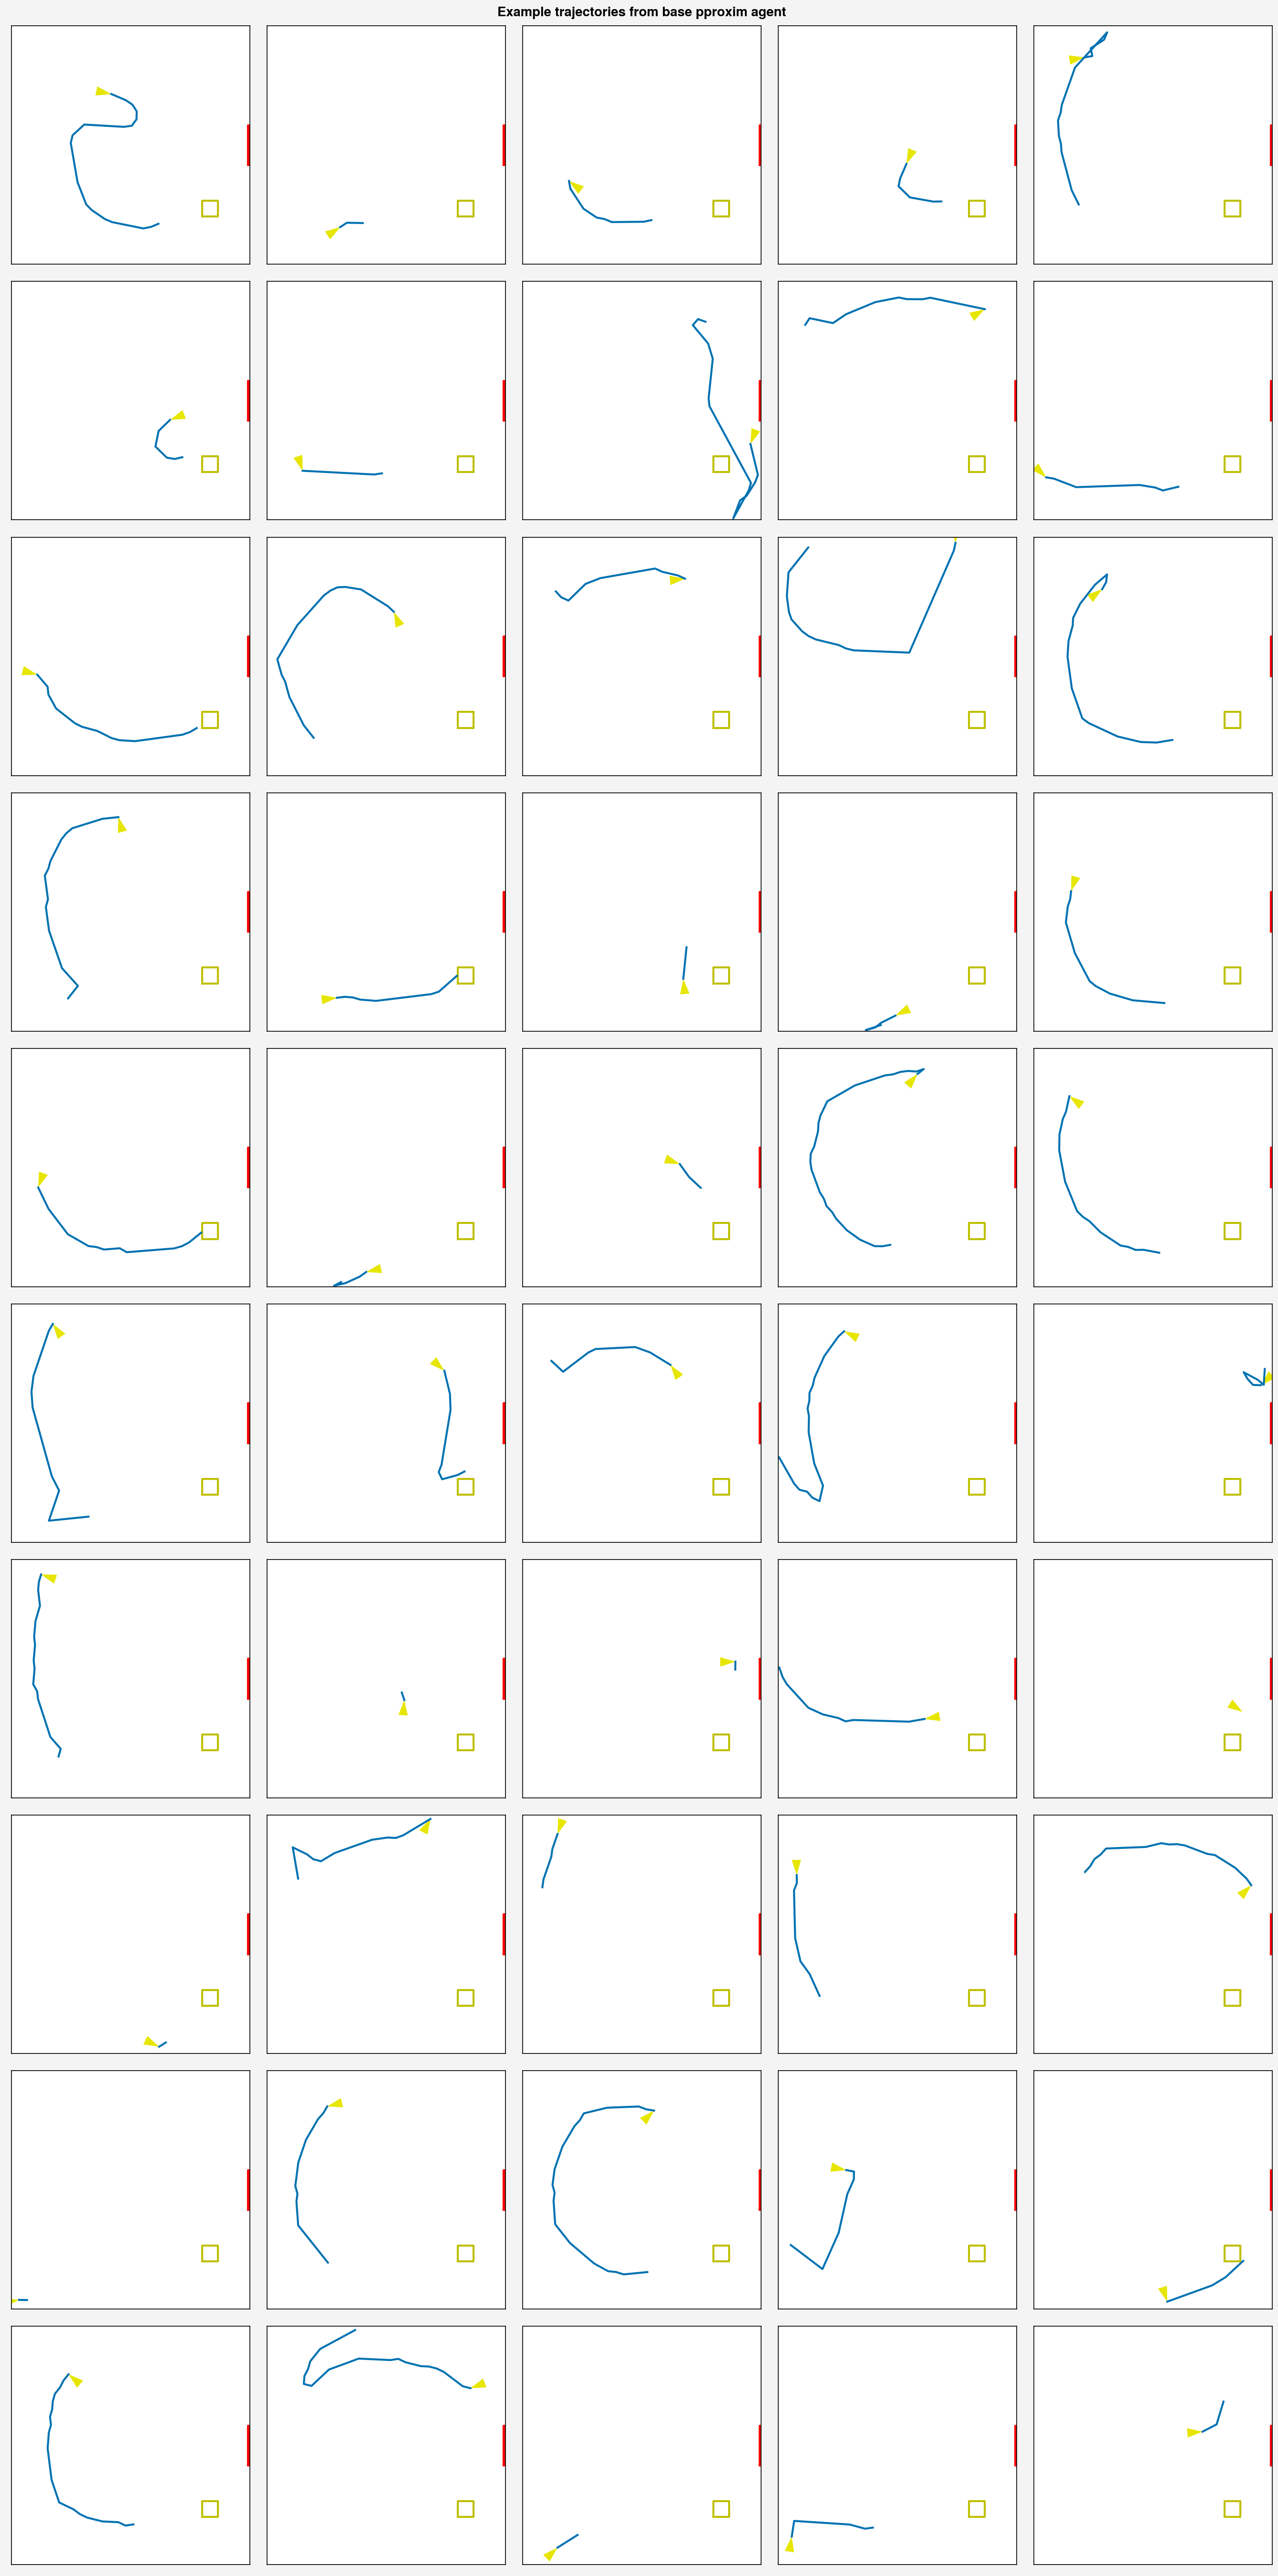

In [78]:
fig = pplt.figure()
ax = fig.subplots(nrows=10, ncols=5, xlim=[0, 300], ylim=[0, 300])
ax.format(xticks=[], yticks=[], suptitle='Example trajectories from base pproxim agent')
for i in range(len(ax)):
    p = ep_pos[i]
    a = ep_angles[i]
    draw_character(p[0], a[0], ax=ax[i], size=20)
    draw_box(ax=ax[i])
    draw_box(corner=np.array([298, 125]), size=[2, 50], c='r', ax=ax[i])
    ax[i].plot(p.T[0], p.T[1])
    

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


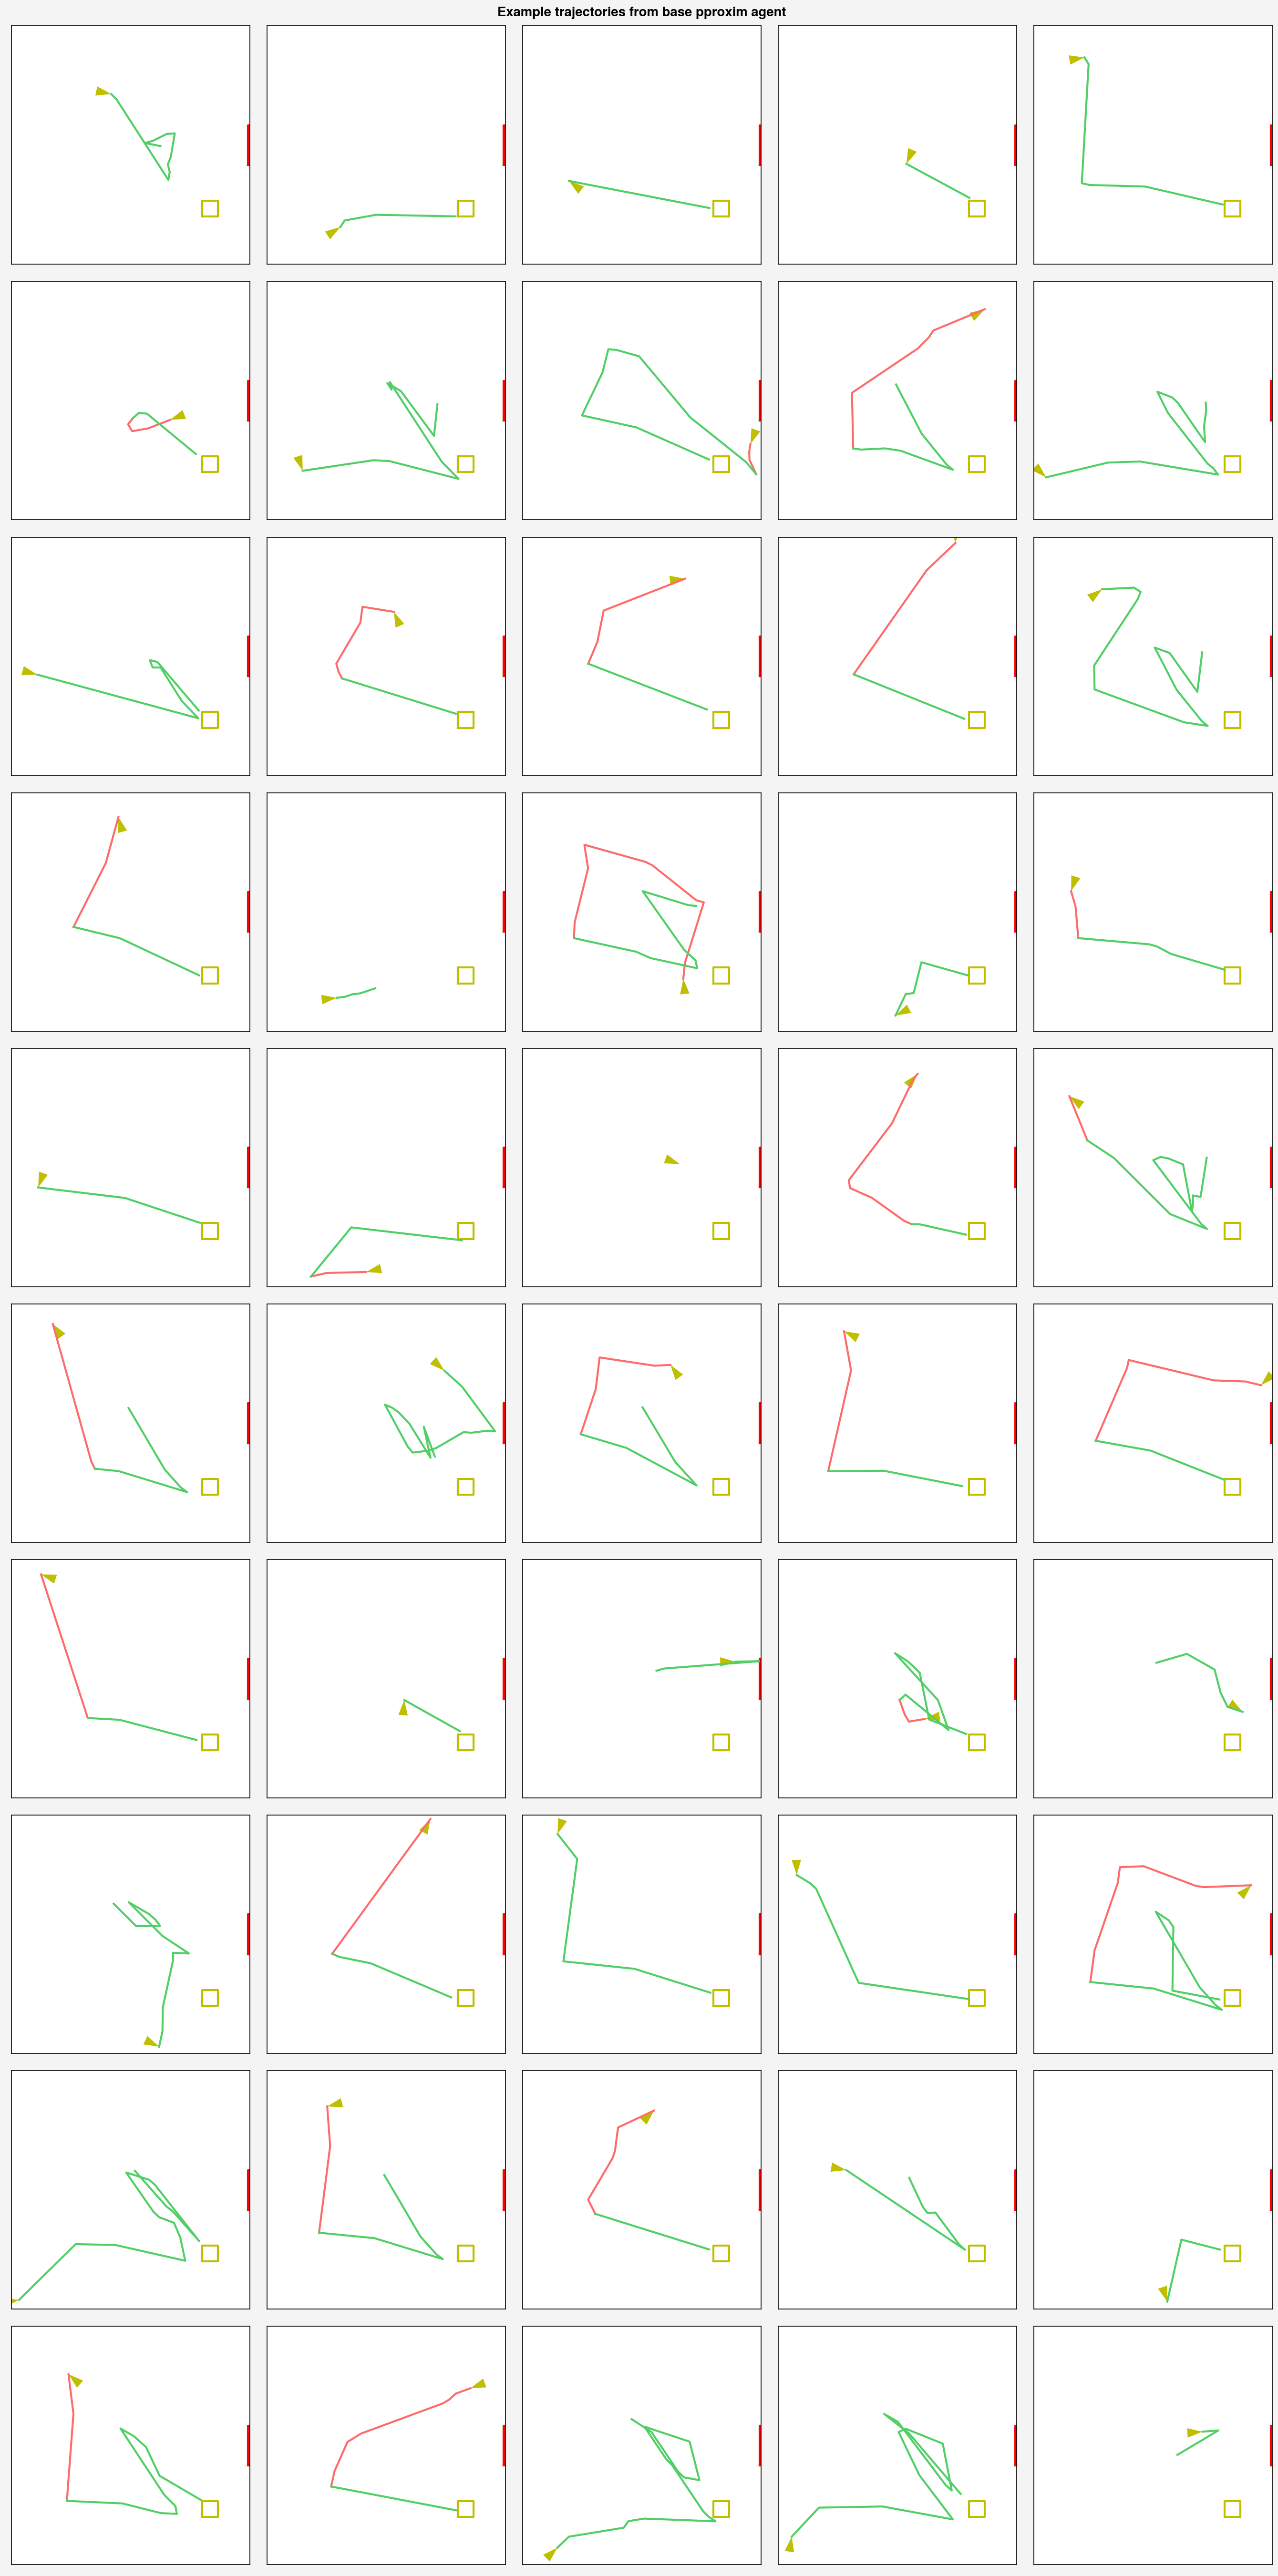

In [87]:
fig = pplt.figure()
ax = fig.subplots(nrows=10, ncols=5, xlim=[0, 300], ylim=[0, 300])
ax.format(xticks=[], yticks=[], suptitle='Example trajectories from base pproxim agent')
for i in range(len(ax)):
    p = ep_pos[i]
    a = ep_angles[i]
    draw_character(p[0], a[0], ax=ax[i], size=20, color='y')
    draw_box(ax=ax[i])
    draw_box(corner=np.array([298, 125]), size=[2, 50], c='r', ax=ax[i])

    seen_idxs = np.argwhere(ep_poster_seen[i].squeeze()).squeeze()
    if len(seen_idxs) > 0:
        ax[i].plot(p.T[0, :seen_idxs[0]], p.T[1, :seen_idxs[0]], c='red5')
        ax[i].plot(p.T[0, seen_idxs[0]:], p.T[1, seen_idxs[0]:], c='green5')
    else:
        ax[i].plot(p.T[0], p.T[1], c='red5')
    

In [117]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels = clusterer.fit_predict(reduced)

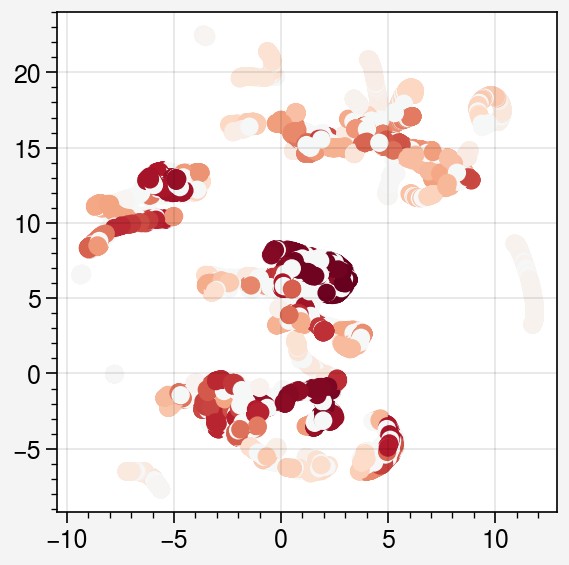

In [114]:
fig, ax = pplt.subplots()
ax.scatter(reduced.T[0], reduced.T[1], c=labels)

# Different network structures

## 2 Width

In [3]:
exp_name = 'nav_pproxim_width2_t2'
model_name = 'nav_poster_netstructure/nav_pproxim_width2'
model, obs_rms = load_checkpoint(exp_name, 2700)
_, _, kwargs = load_model_and_env(model_name, 2)

In [10]:
eps = evalu(model, obs_rms, n=100, env_kwargs=kwargs,
           data_callback=poster_data_callback, with_activations=True)

#Get episodes statistics
stacked = stack_activations(eps['activations'])
pos = np.vstack(eps['data']['pos'])
dones = np.vstack(eps['dones'])
angles = np.vstack(eps['data']['angle'])
poster_seen = np.vstack(eps['data']['poster_seen'])
poster_in_view = np.vstack(eps['data']['poster_in_view'])

ep_pos = split_by_ep(pos, dones)
ep_angles = split_by_ep(angles, dones)
ep_poster_seen = split_by_ep(poster_seen, dones)
ep_poster_in_view = split_by_ep(poster_in_view, dones)

steps = dones_to_timesteps(dones)
ep_steps = split_by_ep(steps, dones)

#Reduce activations of shared layer
# reducer = umap.UMAP(random_state=0, n_neighbors=30, min_dist=0)
# reduced = reducer.fit_transform(stacked['shared_activations'][0])



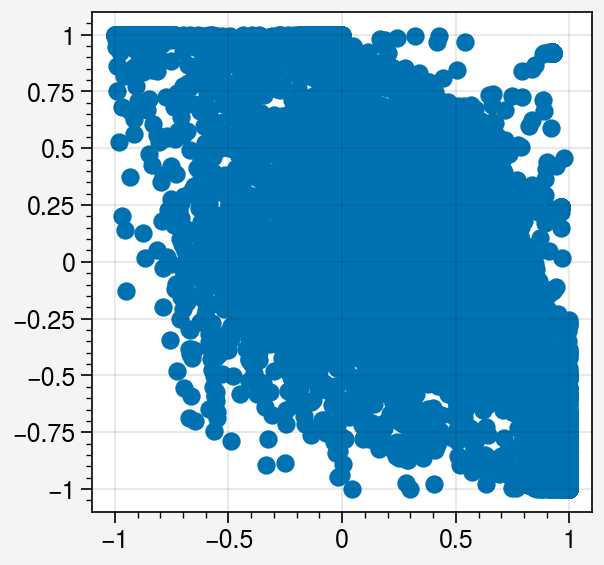

In [9]:
shared = stacked['shared_activations'][0]
fig, ax = pplt.subplots()
ax.scatter(shared.T[0], shared.T[1])

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


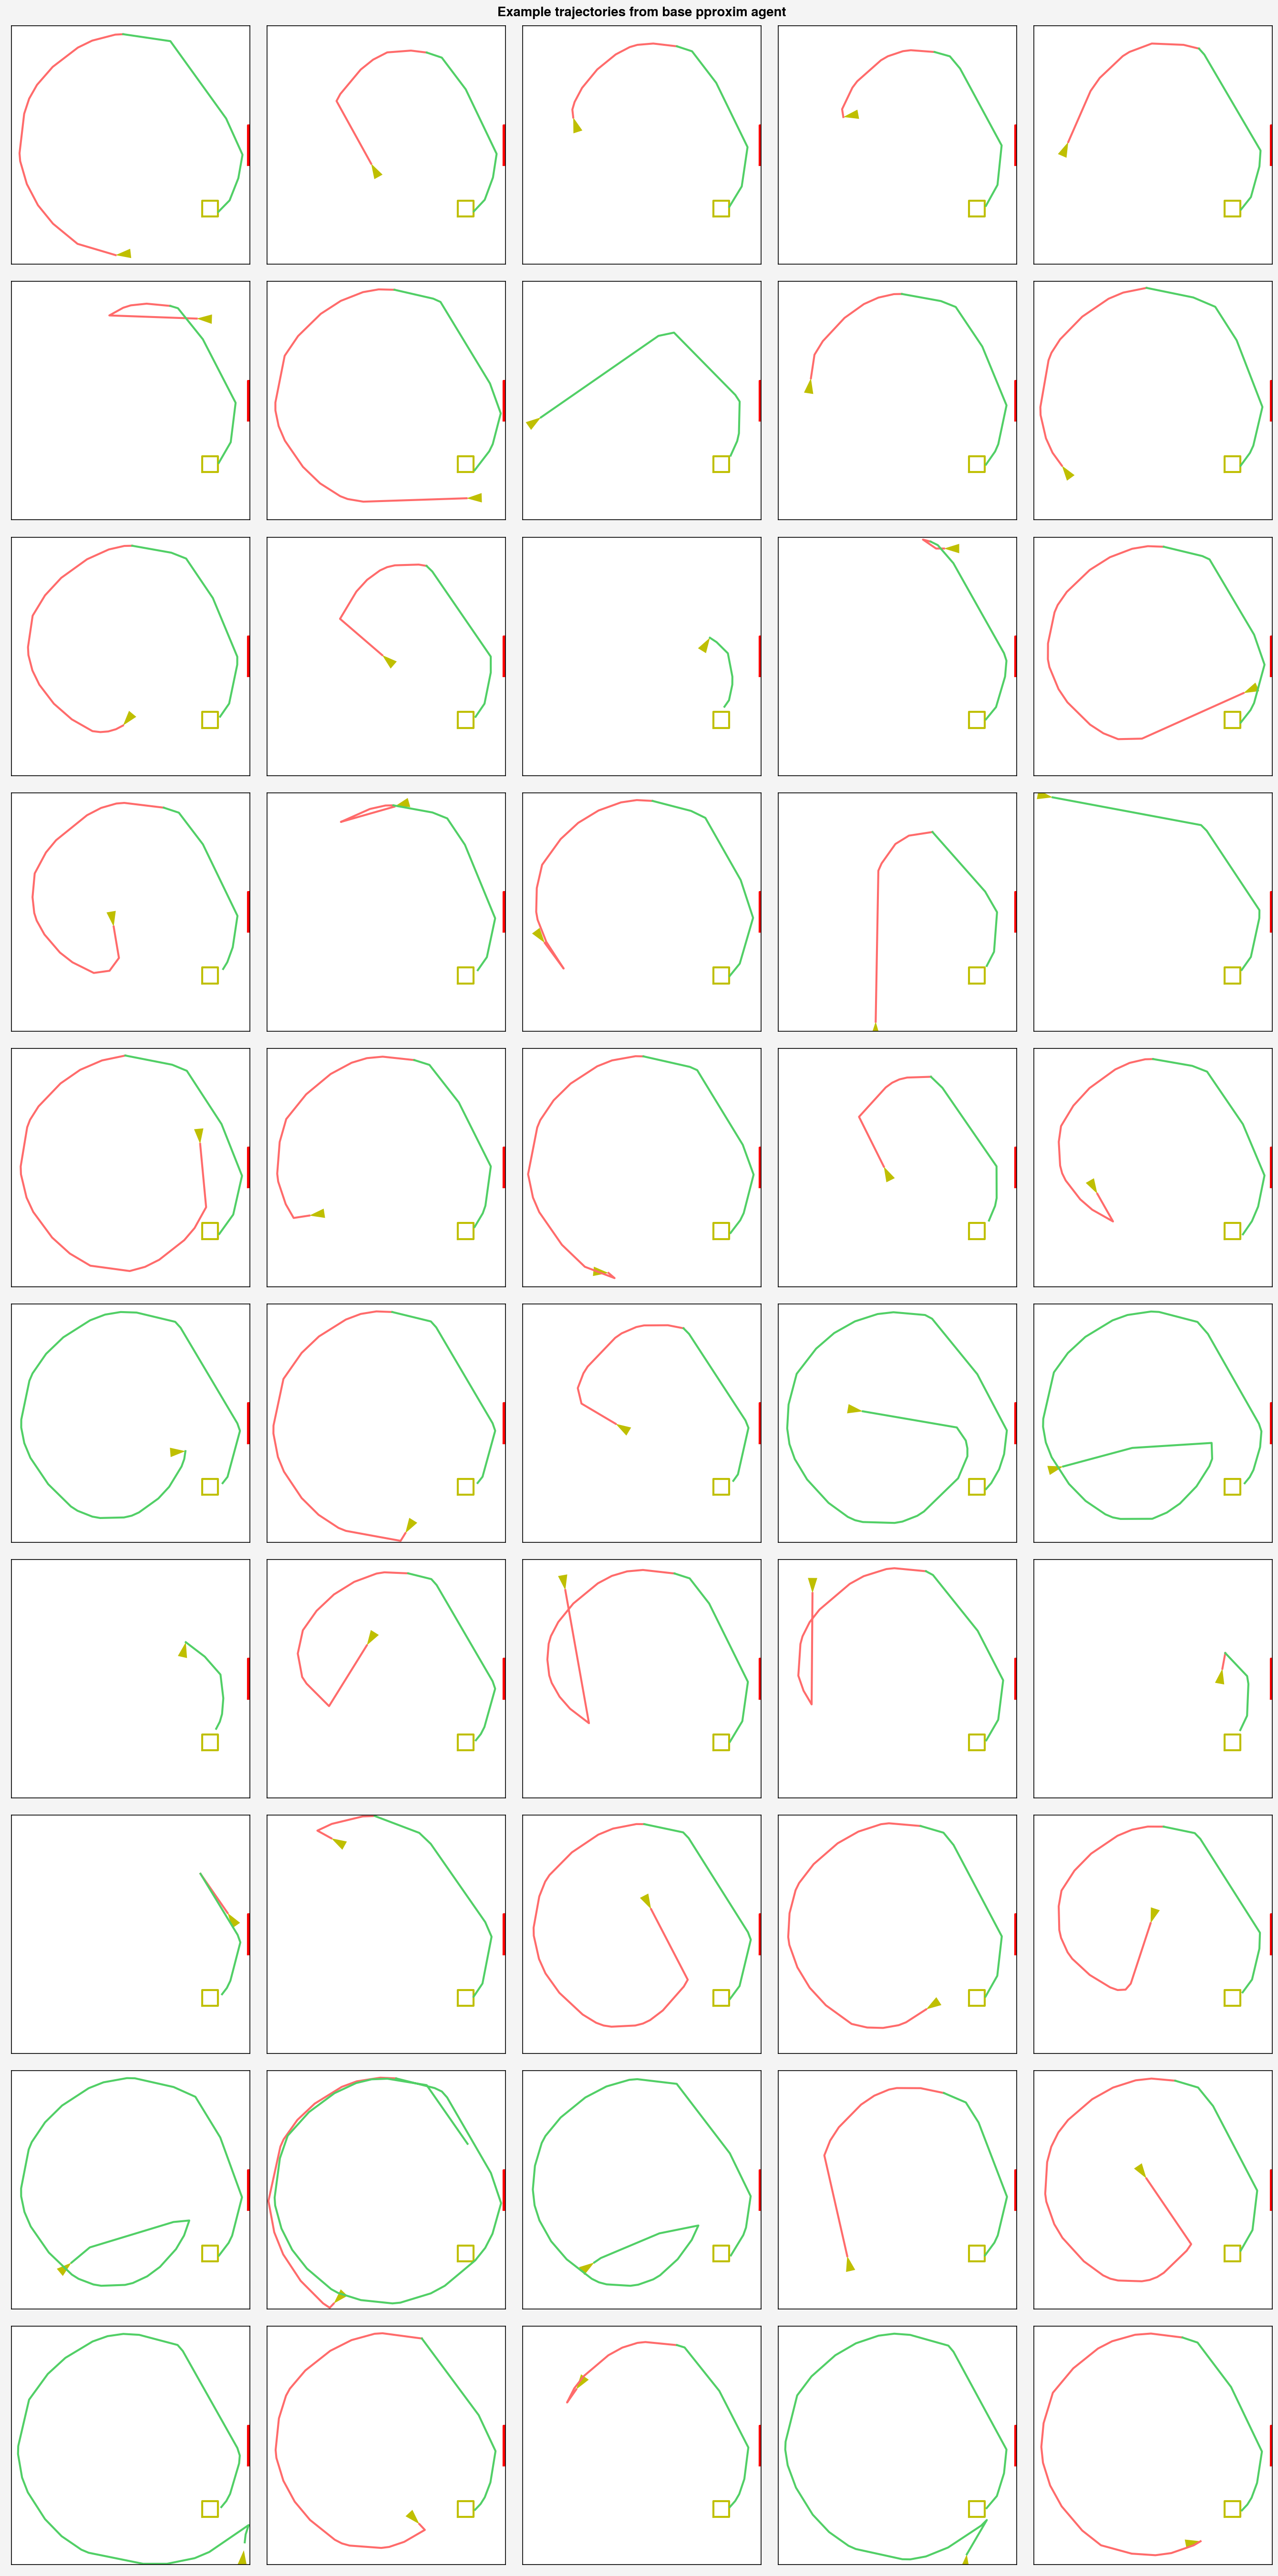

In [11]:
fig = pplt.figure()
ax = fig.subplots(nrows=10, ncols=5, xlim=[0, 300], ylim=[0, 300])
ax.format(xticks=[], yticks=[], suptitle='Example trajectories from base pproxim agent')
for i in range(len(ax)):
    p = ep_pos[i]
    a = ep_angles[i]
    draw_character(p[0], a[0], ax=ax[i], size=20, color='y')
    draw_box(ax=ax[i])
    draw_box(corner=np.array([298, 125]), size=[2, 50], c='r', ax=ax[i])

    seen_idxs = np.argwhere(ep_poster_seen[i].squeeze()).squeeze()
    if len(seen_idxs) > 0:
        ax[i].plot(p.T[0, :seen_idxs[0]], p.T[1, :seen_idxs[0]], c='red5')
        ax[i].plot(p.T[0, seen_idxs[0]:], p.T[1, seen_idxs[0]:], c='green5')
    else:
        ax[i].plot(p.T[0], p.T[1], c='red5')
    

## 16 Width

In [12]:
exp_name = 'nav_pproxim_width16_t2'
model_name = 'nav_poster_netstructure/nav_pproxim_width16'
model, obs_rms = load_checkpoint(exp_name, 3800)
_, _, kwargs = load_model_and_env(model_name, 2)

In [13]:
eps = evalu(model, obs_rms, n=100, env_kwargs=kwargs,
           data_callback=poster_data_callback, with_activations=True)

#Get episodes statistics
stacked = stack_activations(eps['activations'])
pos = np.vstack(eps['data']['pos'])
dones = np.vstack(eps['dones'])
angles = np.vstack(eps['data']['angle'])
poster_seen = np.vstack(eps['data']['poster_seen'])
poster_in_view = np.vstack(eps['data']['poster_in_view'])

ep_pos = split_by_ep(pos, dones)
ep_angles = split_by_ep(angles, dones)
ep_poster_seen = split_by_ep(poster_seen, dones)
ep_poster_in_view = split_by_ep(poster_in_view, dones)

steps = dones_to_timesteps(dones)
ep_steps = split_by_ep(steps, dones)

#Reduce activations of shared layer
# reducer = umap.UMAP(random_state=0, n_neighbors=30, min_dist=0)
# reduced = reducer.fit_transform(stacked['shared_activations'][0])



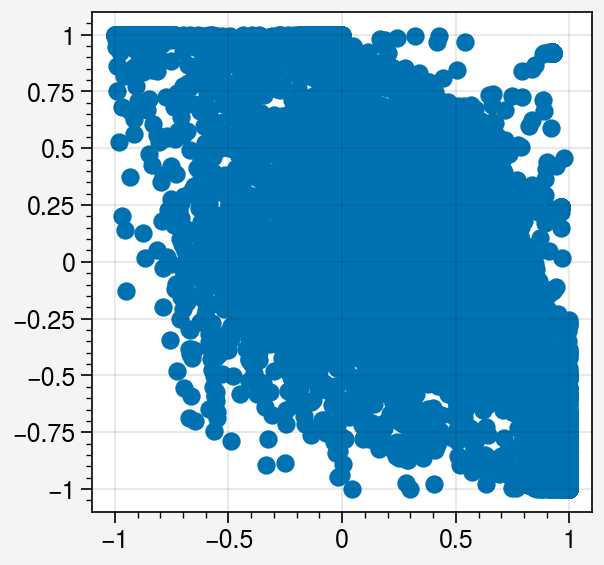

In [9]:
shared = stacked['shared_activations'][0]
fig, ax = pplt.subplots()
ax.scatter(shared.T[0], shared.T[1])

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


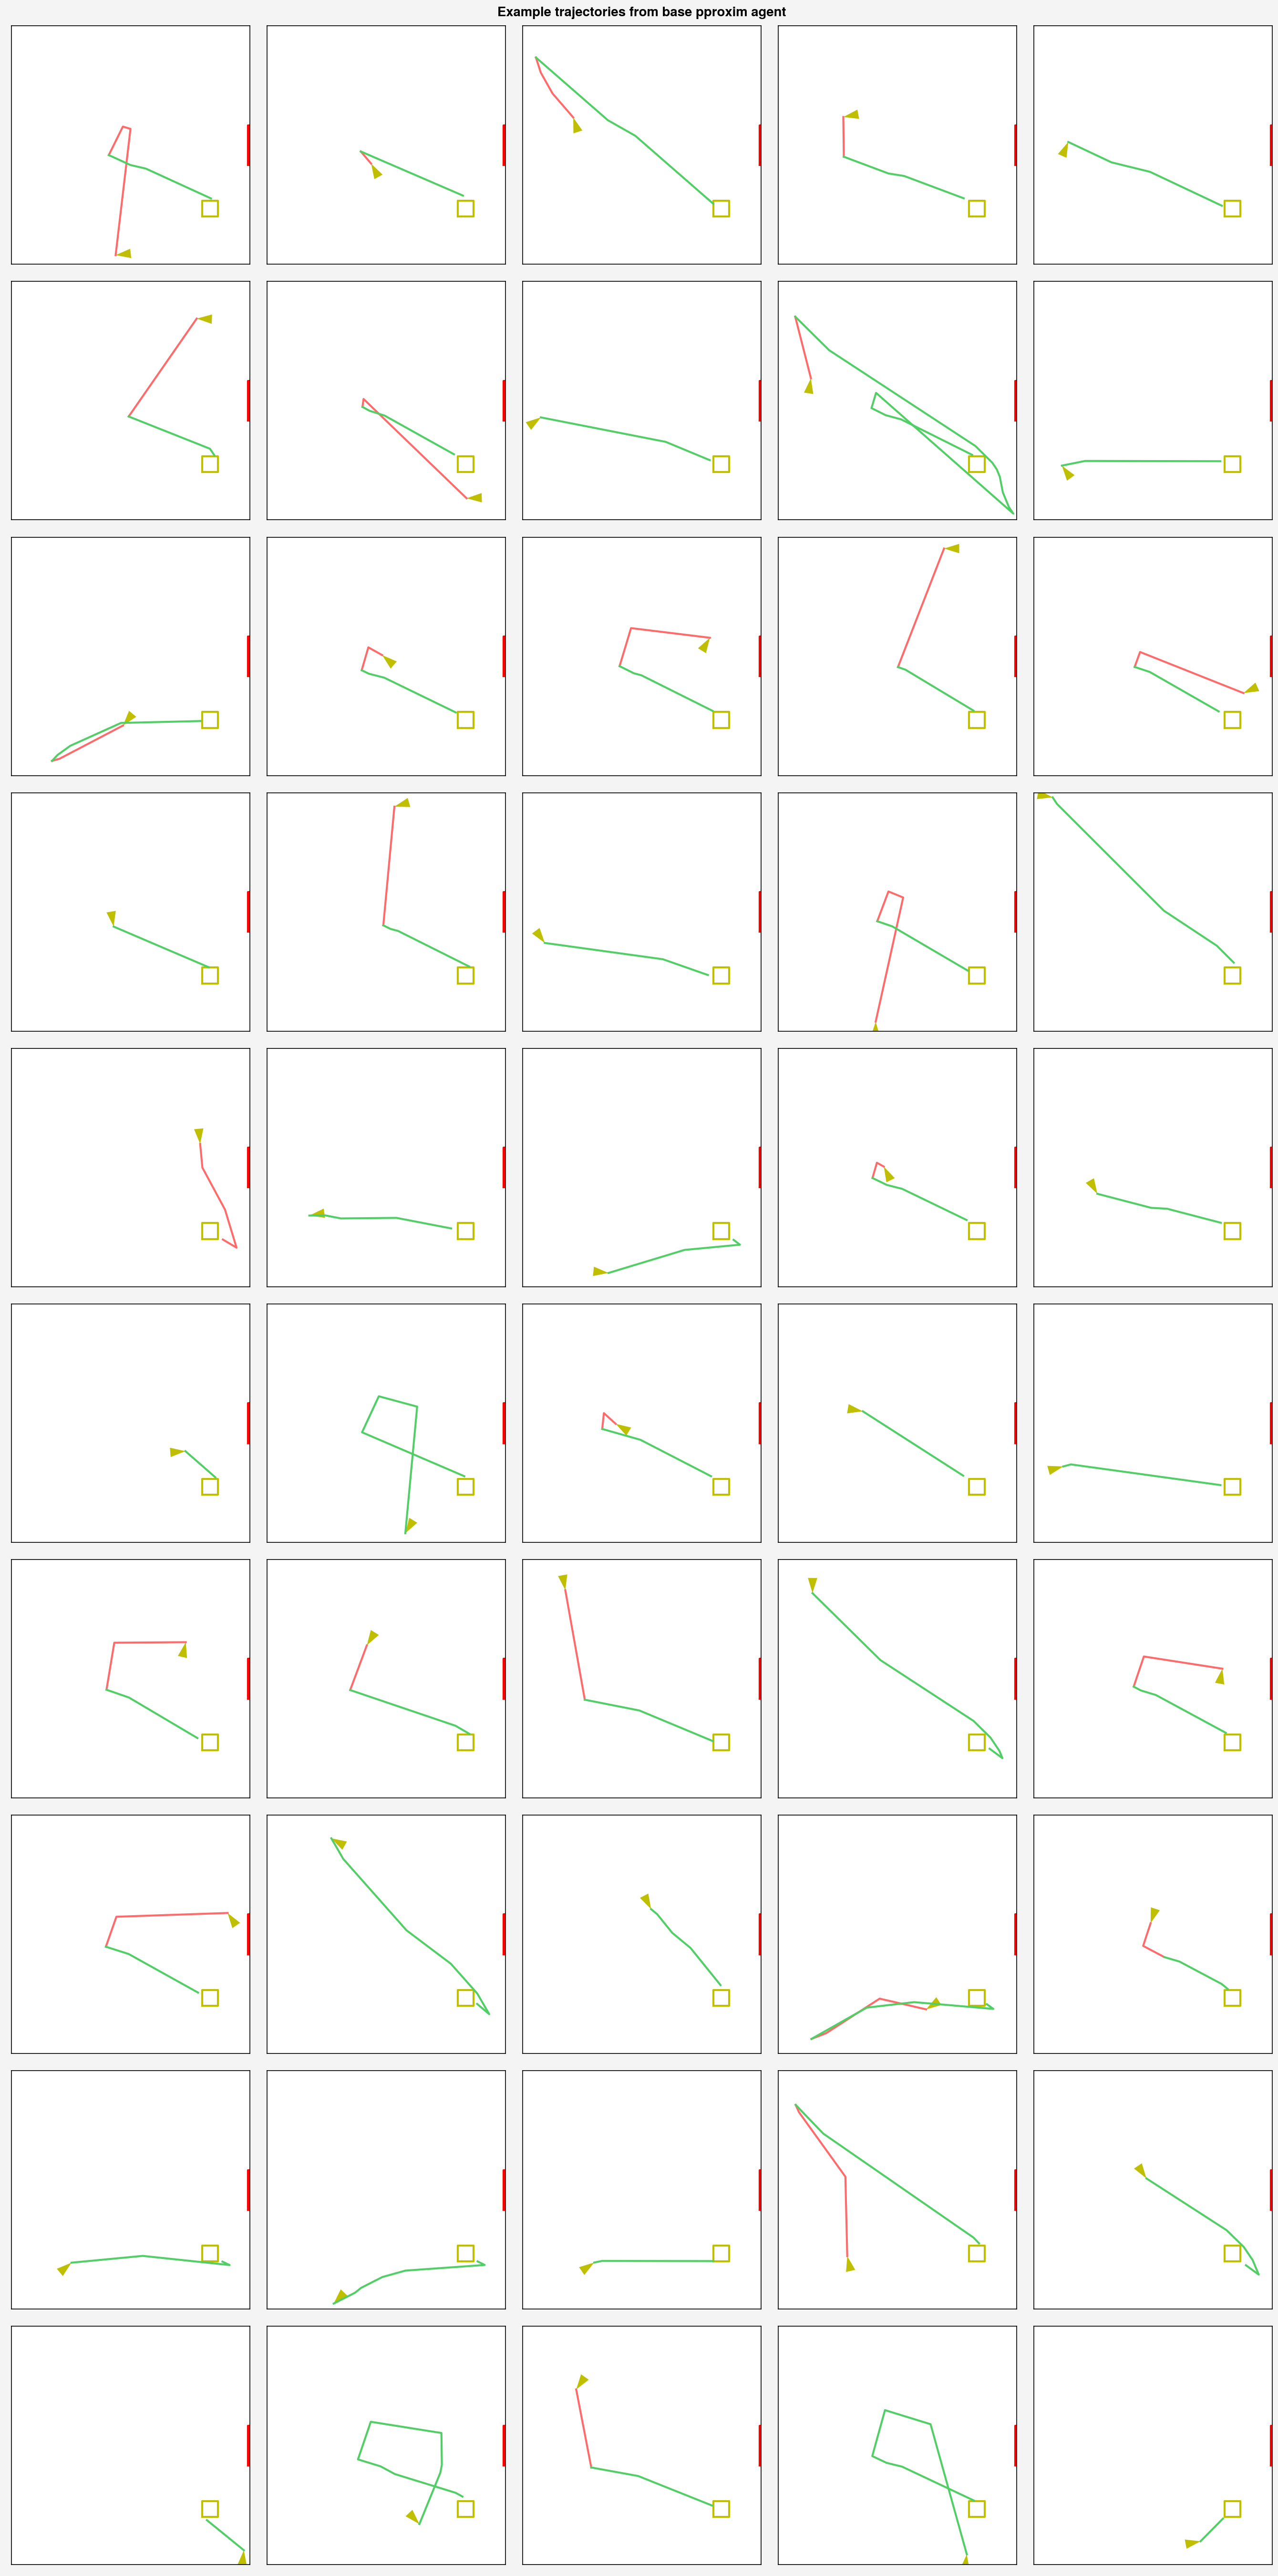

In [14]:
fig = pplt.figure()
ax = fig.subplots(nrows=10, ncols=5, xlim=[0, 300], ylim=[0, 300])
ax.format(xticks=[], yticks=[], suptitle='Example trajectories from base pproxim agent')
for i in range(len(ax)):
    p = ep_pos[i]
    a = ep_angles[i]
    draw_character(p[0], a[0], ax=ax[i], size=20, color='y')
    draw_box(ax=ax[i])
    draw_box(corner=np.array([298, 125]), size=[2, 50], c='r', ax=ax[i])

    seen_idxs = np.argwhere(ep_poster_seen[i].squeeze()).squeeze()
    if len(seen_idxs) > 0:
        ax[i].plot(p.T[0, :seen_idxs[0]], p.T[1, :seen_idxs[0]], c='red5')
        ax[i].plot(p.T[0, seen_idxs[0]:], p.T[1, seen_idxs[0]:], c='green5')
    else:
        ax[i].plot(p.T[0], p.T[1], c='red5')
    

In [26]:
np.argmax([len(ep) for ep in ep_pos])

72

In [20]:
shared = stacked['shared_activations'][0]

neighbors = [10, 15, 30, 60]
min_dist = [0, 0.1, 0.3, 0.5]
all_umaps = []
for i, neighbor in enumerate(neighbors):
    all_umaps.append([])
    for j, dist in enumerate(min_dist):
        all_umaps[i].append(None)
activations = stacked['shared_activations'][0]

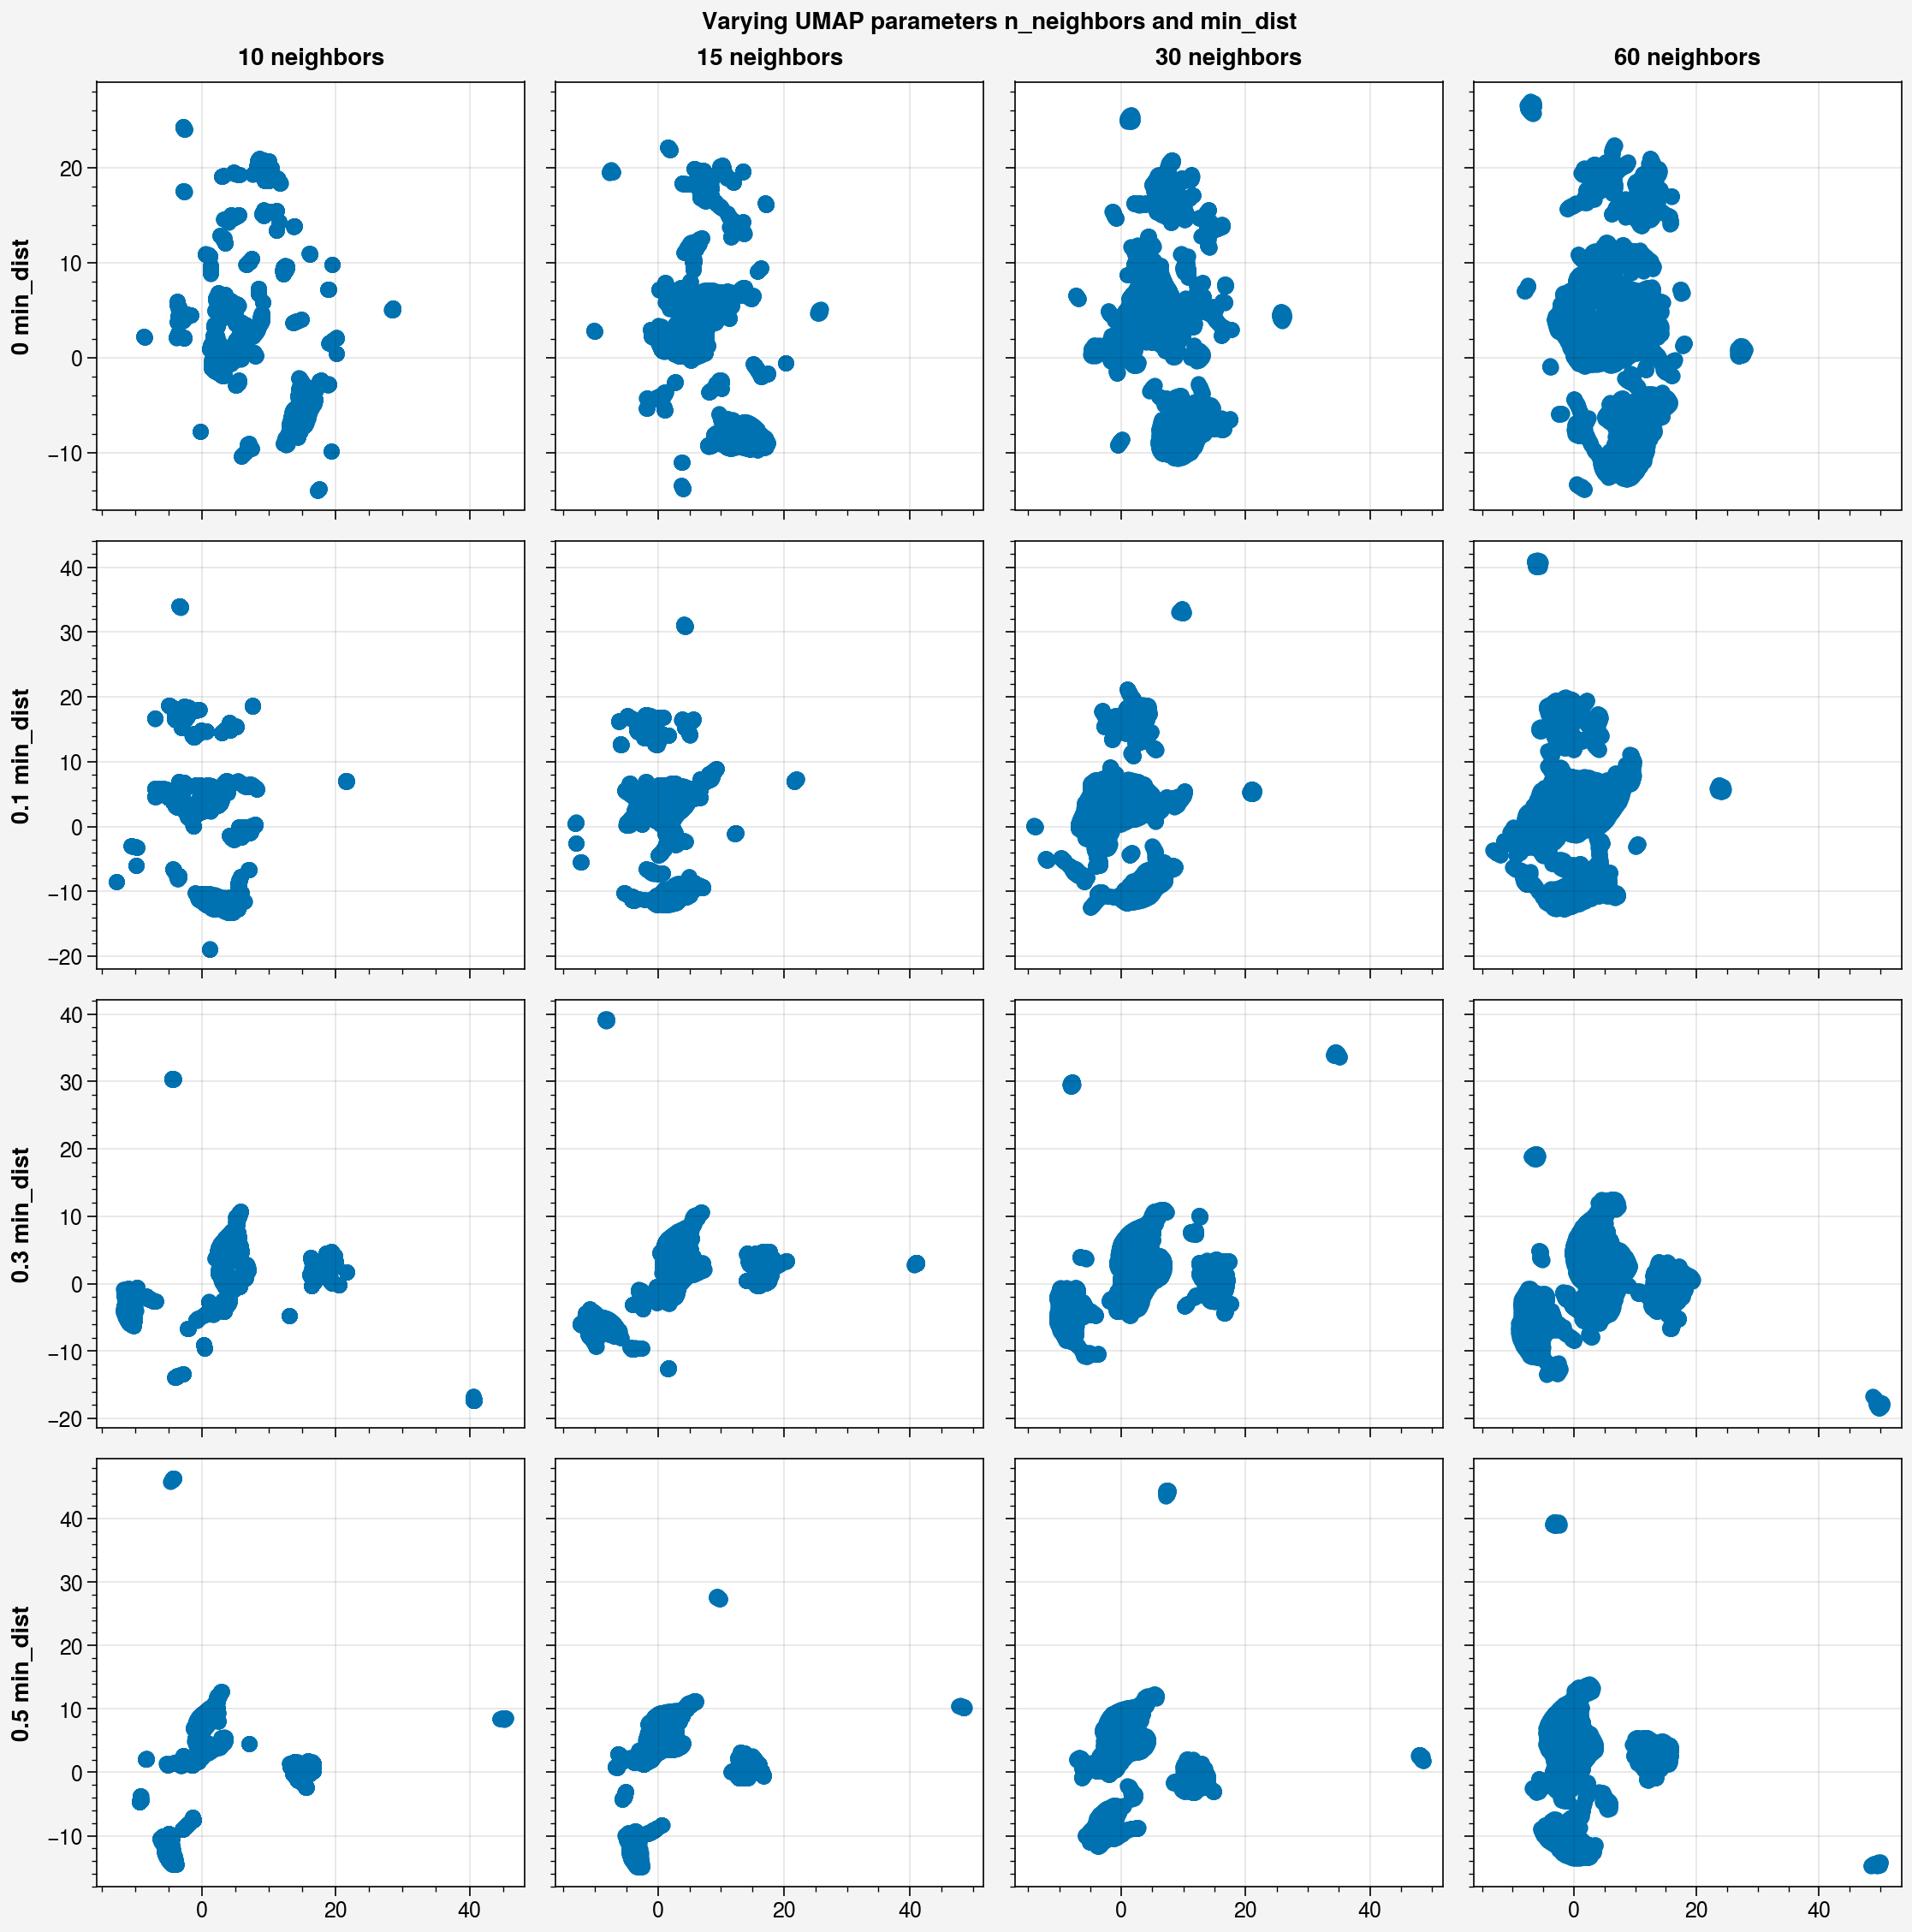

In [20]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
ax.format(toplabels=[f'{n} neighbors' for n in neighbors],
          leftlabels=[f'{w} min_dist' for w in min_dist],
          suptitle='Varying UMAP parameters n_neighbors and min_dist')

for i, neighbor in enumerate(neighbors):
    for j, dist in enumerate(min_dist):
        if all_umaps[i][j] == None:
            #Generate mapper
            reducer = umap.UMAP(random_state=0, n_neighbors=neighbor, min_dist=dist)
            reducer.fit(activations)
            all_umaps[i][j] = reducer
        else:
            reducer = all_umaps[i, j]
        
        reduced = reducer.transform(activations)
        ax[i, j].scatter(reduced.T[0], reduced.T[1])
        

In [36]:
ep_activations = split_by_ep(activations, dones)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ep_activations[0].T[0], ep_activations)

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


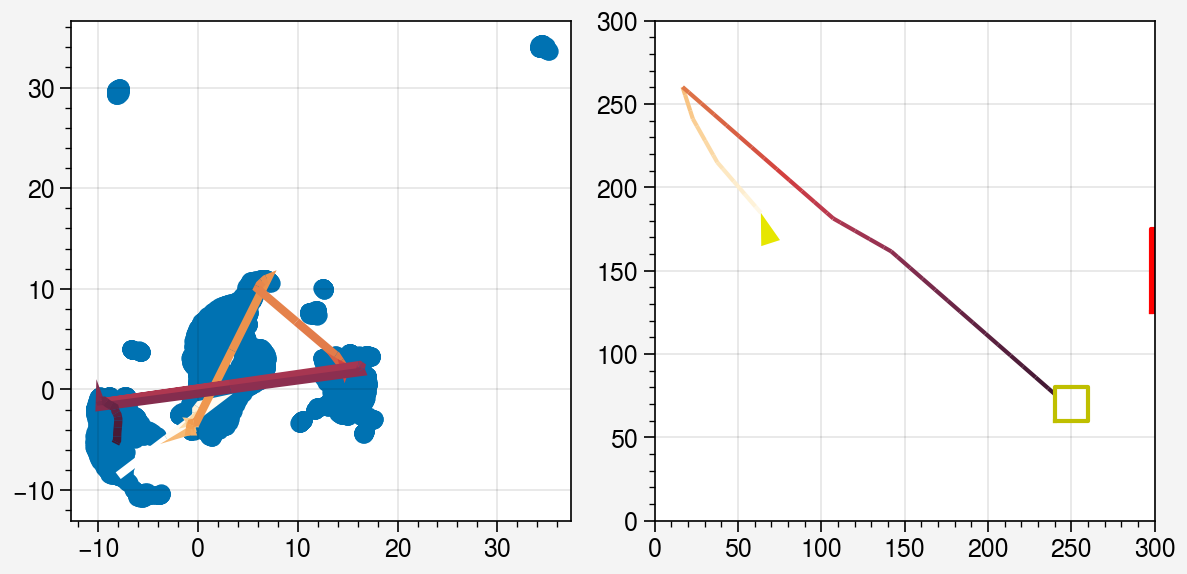

In [43]:
# ep_pruned_pos = prune_fail_episodes(pos, dones)
# ep_pruned_angle = prune_fail_episodes(angles, dones)
# ep_pruned_actions = prune_fail_episodes(eps['actions'], dones)
#Use min_dist 0.5 and 30 neighbors
reducer = all_umaps[2][2]
ep_num = 2

fig, ax = pplt.subplots(ncols=2, share=False)
# ax[0].format(xlim=[-10, 20], ylim=[-15, 20])
reduced = reducer.transform(activations)
ax[0].scatter(reduced.T[0], reduced.T[1])
# traj = reducer.transform(ep_pos[ep_num]).T
traj = reducer.transform(ep_activations[ep_num]).T
ax[0].parametric(traj[0], traj[1], lw=3)

# p = ep_pruned_pos[ep_num]
# a = ep_pruned_angle[ep_num]

p = ep_pos[ep_num]
a = ep_angles[ep_num]
ax[1].parametric(p.T[0], p.T[1])
ax[1].format(xlim=[0, 300], ylim=[0, 300])
draw_character(p[0], a[0], ax=ax[1], size=20)
draw_box(corner=np.array([298, 125]), size=[2, 50], c='r', ax=ax[1])
draw_box(ax=ax[1])
# print(torch.vstack(ep_pruned_actions[ep_num]).squeeze())

### Individual Episodes

In [71]:
grid_points

array([[255.12212052,  80.67663674],
       [239.15809902,  73.48773403],
       [239.15809902,  77.01194417],
       [256.89465866,  80.67663674],
       [239.15809902,  73.03950114],
       [239.15809902,  75.94885574],
       [239.15809902,  73.72403322],
       [239.15809902,  75.30072044],
       [239.15809902,  75.98279433],
       [256.9037687 ,  80.67663674],
       [239.15809902,  75.36655199],
       [239.15809902,  77.16905143],
       [255.88025438,  80.67663674],
       [255.80254065,  80.67663674],
       [257.09504842,  80.80943266],
       [239.15809902,  73.20349728],
       [239.15809902,  75.82217667],
       [239.15809902,  76.47274469],
       [239.15809902,  76.58959685],
       [256.06193668,  80.67663674],
       [239.15809902,  75.29842156],
       [239.15809902,  74.63242554],
       [256.85580437,  80.67663674],
       [255.77277929,  80.80943266],
       [255.73395622,  80.67663674]])

In [73]:
grid = np.linspace(5, 295, 5)
grid_points = []
for x in grid:
    for y in grid:
        grid_points.append(np.array([x, y]))
grid_points = np.vstack(grid_points)

In [89]:
exp_name = 'nav_pproxim_width16_t2'
model_name = 'nav_poster_netstructure/nav_pproxim_width16'
model, obs_rms = load_checkpoint(exp_name, 3800)
_, _, kwargs = load_model_and_env(model_name, 2)

grid = np.linspace(5, 295, 5)
grid_points = []
for x in grid:
    for y in grid:
        grid_points.append(np.array([x, y]))
grid_points = np.vstack(grid_points)

angle = np.pi/2
angles = [0, 1.57, 3.14, -1.57]
all_results = defaultdict(list)

for angle in tqdm(angles):
    for i in range(len(grid_points)):
        point = grid_points[i].copy()
        kwargs['fixed_reset'] = [point, angle]
        results = evalu(model, obs_rms, n=1, env_kwargs=kwargs,
                        data_callback=poster_data_callback, with_activations=True)
        all_results[angle].append(results)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/it]


In [94]:
[results['data']['pos'][3] for result in all_results[1.57]]

[array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.]),
 array([295., 295.])]

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


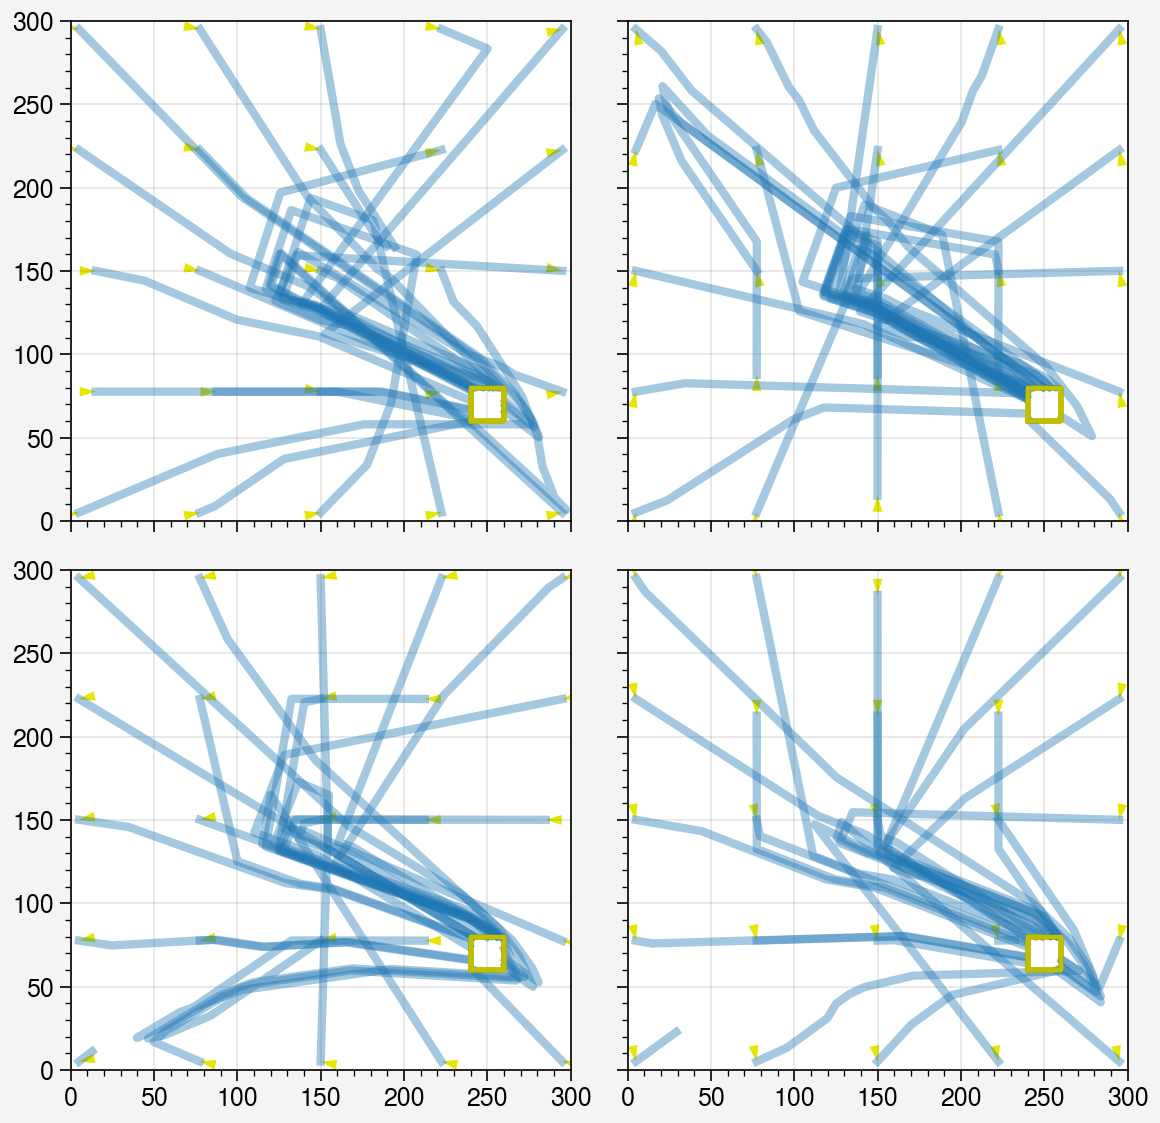

In [95]:

fig, ax = pplt.subplots(nrows=2, ncols=2)
ax.format(xlim=[0, 300], ylim=[0, 300])

colors = pplt.Cycle('default').by_key()['color']
color = colors[0]
for i, angle in enumerate(angles):
    for result in all_results[angle]:
        pos = np.vstack(result['data']['pos'])
        angles = np.vstack(result['data']['angle'])
        ax[i].plot(pos.T[0], pos.T[1], alpha=0.4, lw=3, c=color)
        draw_character(pos[0], angles[0], ax=ax[i])
        draw_box(ax=ax[i])

In [60]:
all_stacked = [stack_activations(results['activations']) for result in all_results]

In [64]:
all_stacked[0]['shared_activations'].shape

torch.Size([1, 61, 16])

In [58]:
results['activations']

[{'shared_activations': [tensor([[-2.1942e-01,  1.9065e-02, -5.9605e-06,  3.9202e-01,  4.0980e-03,
             7.0460e-01, -2.0793e-01,  4.5944e-01, -2.2726e-01, -9.5505e-01,
            -9.2540e-01, -7.2464e-01, -5.7303e-01,  2.1295e-01, -2.4379e-03,
            -7.1506e-02]])],
  'actor_activations': [tensor([[ 0.3659, -0.9225, -0.7043,  0.9939, -0.9171,  0.9228,  0.0608, -0.4922,
             0.5241,  0.6586, -0.4947,  0.4802, -0.7567, -0.1126, -0.8840, -0.3993]]),
   tensor([[ 0.9822, -0.7095,  0.9699, -0.9491, -0.9933, -0.7908, -0.8963, -0.9964,
             0.3185, -0.9456,  0.9445, -0.9038,  0.6877, -0.9930, -0.8564, -0.1767]])],
  'critic_activations': [tensor([[-0.8599, -0.9913,  0.1197,  0.6306, -0.9676,  0.9804, -0.9060, -0.0766,
            -0.9609,  0.6969, -0.5755, -0.5670, -0.9447,  0.6011, -0.2764,  0.9821]]),
   tensor([[-9.9837e-01, -9.2394e-01, -9.8733e-01,  9.9120e-01,  9.6698e-01,
            -2.7253e-04,  9.8759e-01, -5.4835e-01, -7.7934e-01,  7.1727e-01,
       

In [1]:
import gym
import torch
import sys
sys.path.append('../')
from env.gym_nav.envs.nav_env_flat import NavEnvFlat
kwargs2 = {
    'task_structure': 3,
    'rew_structure': 'goal',
    'num_objects': 0,
    'wall_colors': 1,
    'poster': 0,
    'num_rays': 5,
    'fov': 0.8,
    'turn_speed': 0.5,
    'move_speed': 20,
    'character_reset_pos': 1
}
env = gym.make('NavEnv-v0', **kwargs2)

C:\Users\14and\anaconda3\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment NavEnv-v0
  logger.warn("Overriding environment {}".format(id))
C:\Users\14and\anaconda3\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment NavEnv-v1
  logger.warn("Overriding environment {}".format(id))
C:\Users\14and\anaconda3\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment MorrisEnv-v0
  logger.warn("Overriding environment {}".format(id))
C:\Users\14and\anaconda3\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment Gridworld-v0
  logger.warn("Overriding environment {}".format(id))


In [2]:
env.reset()

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.19258694, 0.2444846 , 0.23416327, 0.23032348, 0.23244983])

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.01497807, 0.01574051, 0.01704347, 0.01911394, 0.02240863]), 0, False, {'auxiliary': array([], dtype=float64)})


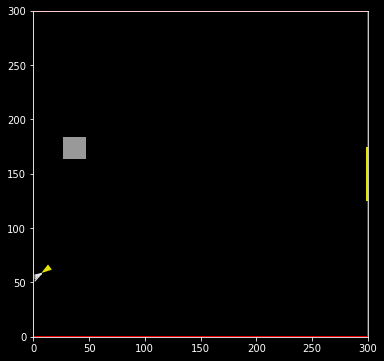

In [215]:
print(env.step(torch.tensor([0])))
# env.reset()
env.render('human')

In [40]:
env.character.rays[0].update()

IndexError: list index out of range

In [36]:
env.character.pos

array([ 48.53194575, 244.0464359 ])

In [42]:
env.step(torch.tensor([1]))

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.07197739, 0.07448352, 0.07926847, 0.08708784, 0.09943686]),
 0,
 False,
 {'auxiliary': array([], dtype=float64)})